In [1]:
# Base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() 
import gc # memory management
import timeit

In [2]:
# Model
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from joblib import dump

import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.impute import KNNImputer
from sklearn.metrics import roc_auc_score,classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

from bayes_opt import BayesianOptimization

import shap

In [3]:
# Configuration
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

# -----

# TRAIN-TEST SPLIT

In [4]:
df = pd.read_feather("full_df_ready_feather")

In [5]:
df.shape

(356249, 675)

In [6]:
pd.Series(df.TARGET.unique())

0   1.00
1   0.00
2    NaN
dtype: float16

In [7]:
 # Uniquement les lignes dont la colonne Target est 0 ou 1, mais pas NaN. 
train = df[df.TARGET.isnull() == False]
print(train.shape)
del df

(307505, 675)


A cause de problèmes de mémoire, il faut travailler uniquement sur un échantillon du df 

In [8]:
# quel taille d'échantillon choisir? 
76880*100/train.shape[0]

25.001219492365976

In [9]:
# On extrait 25% du df
train_25 = train.sample(n=76880, replace=False, random_state=42)
print(train_25.shape)
del train

(76880, 675)


In [10]:
pd.Series(train_25.TARGET.unique())

0   0.00
1   1.00
dtype: float16

In [11]:
train_25.head(2)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,REGION,NAME_TYPE_SUITE_CHILDREN,NAME_TYPE_SUITE_FAMILY,NAME_TYPE_SUITE_RARE,NAME_TYPE_SUITE_SPOUSE_PARTNER,NAME_TYPE_SUITE_UNACCOMPANIED,NAME_INCOME_TYPE_COMMERCIAL_ASSOCIATE,NAME_INCOME_TYPE_PENSIONER,NAME_INCOME_TYPE_RARE,NAME_INCOME_TYPE_STATE_SERVANT,NAME_INCOME_TYPE_WORKING,NAME_EDUCATION_TYPE_HIGHER_EDUCATION,NAME_EDUCATION_TYPE_INCOMPLETE_HIGHER,NAME_EDUCATION_TYPE_LOWER_SECONDARY,NAME_EDUCATION_TYPE_SECONDARY_SECONDARY_SPECIAL,NAME_FAMILY_STATUS_CIVIL_MARRIAGE,NAME_FAMILY_STATUS_MARRIED,NAME_FAMILY_STATUS_SEPARATED,NAME_FAMILY_STATUS_SINGLE_NOT_MARRIED,NAME_FAMILY_STATUS_UNKNOWN,NAME_FAMILY_STATUS_WIDOW,OCCUPATION_TYPE_ACCOUNTANTS,OCCUPATION_TYPE_CORE_STAFF,OCCUPATION_TYPE_DRIVERS,OCCUPATION_TYPE_HR_STAFF,OCCUPATION_TYPE_HIGH_SKILL_TECH_STAFF,OCCUPATION_TYPE_LABORERS,OCCUPATION_TYPE_LOW_SKILL_LABORERS,OCCUPATION_TYPE_MANAGERS,OCCUPATION_TYPE_MEDICINE_STAFF,OCCUPATION_TYPE_REALTY_AGENTS,OCCUPATION_TYPE_SALES_STAFF,OCCUPATION_TYPE_SECRETARIES,ORGANIZATION_TYPE_AGRICULTURE,ORGANIZATION_TYPE_BUSINESS_ENTITY,ORGANIZATION_TYPE_CONSTRUCTION,ORGANIZATION_TYPE_EDUCATION,ORGANIZATION_TYPE_FINANCE,ORGANIZATION_TYPE_GOVERNMENT,ORGANIZATION_TYPE_HOTELRESTAURANT,ORGANIZATION_TYPE_HOUSE,ORGANIZATION_TYPE_INDUSTRY,ORGANIZATION_TYPE_OTHER,ORGANIZATION_TYPE_PUBLIC,ORGANIZATION_TYPE_SECURITY,ORGANIZATION_TYPE_SELF_EMPLOYED,ORGANIZATION_TYPE_SERVICES,ORGANIZATION_TYPE_TRADE,ORGANIZATION_TYPE_TRANSPORT,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,NEW_EXT_MEAN,NEW_GOODS_CREDIT,NEW_ANNUITY_INCOME_PERC,NEW_C_GP,NEW_APP_AGE,NEW_INCOME_PER_PERSON,NEW_PAYMENT_RATE,NEW_APP_GOODSAMT_CREDIT,NEW_LOAN_VALUE_RATIO,NEW_DAYS_EMPLOYED_PERC,NEW_INCOME_PER_PERSON_PERC_PAYMENT_RATE_INCOME_PER_PERSON,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_CNT_INSTALMENT_MAX,POS_CNT_INSTALMENT_MEAN,POS_CNT_INSTALMENT_STD,POS_CNT_INSTALMENT_MIN,POS_CNT_INSTALMENT_MEDIAN,POS_CNT_INSTALMENT_FUTURE_MAX,POS_CNT_INSTALMENT_FUTURE_MEAN,POS_CNT_INSTALMENT_FUTURE_SUM,POS_CNT_INSTALMENT_FUTURE_MIN,POS_CNT_INSTALMENT_FUTURE_MEDIAN,POS_CNT_INSTALMENT_FUTURE_STD,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_ACTIVE_MEAN,POS_NAME_CONTRACT_STATUS_COMPLETED_MEAN,POS_NAME_CONTRACT_STATUS_RARE_MEAN,POS_COUNT,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_SUM,BUREAU_DAYS_CREDIT_MEDIAN,BUREAU_DAYS_CREDIT_STD,BUREAU_DAYS_CREDIT_ENDDATE_MIN,BUREAU_DAYS_CREDIT_ENDDATE_MAX,BUREAU_DAYS_CREDIT_ENDDATE_MEAN,BUREAU_DAYS_CREDIT_ENDDATE_SUM,BUREAU_DAYS_CREDIT_ENDDATE_MEDIAN,BUREAU_DAYS_CREDIT_ENDDATE_STD,BUREAU_DAYS_CREDIT_UPDATE_MIN,BUREAU_DAYS_CREDIT_UPDATE_MAX,BUREAU_DAYS_CREDIT_UPDATE_MEAN,BUREAU_DAYS_CREDIT_UPDATE_SUM,BUREAU_DAYS_CREDIT_UPDATE_MEDIAN,BUREAU_DAYS_CREDIT_UPDATE_STD,BUREAU_CREDIT_DAY_OVERDUE_MIN,BUR

In [12]:
# X - y Split
X = train_25.drop(["TARGET"], axis = 1)
y = train_25.TARGET

print('X shape : ', X.shape)
print('y shape : ', y.shape)

X shape :  (76880, 674)
y shape :  (76880,)


In [13]:
del (train_25)
gc.collect()

30

In [14]:
X.head(2)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,REGION,NAME_TYPE_SUITE_CHILDREN,NAME_TYPE_SUITE_FAMILY,NAME_TYPE_SUITE_RARE,NAME_TYPE_SUITE_SPOUSE_PARTNER,NAME_TYPE_SUITE_UNACCOMPANIED,NAME_INCOME_TYPE_COMMERCIAL_ASSOCIATE,NAME_INCOME_TYPE_PENSIONER,NAME_INCOME_TYPE_RARE,NAME_INCOME_TYPE_STATE_SERVANT,NAME_INCOME_TYPE_WORKING,NAME_EDUCATION_TYPE_HIGHER_EDUCATION,NAME_EDUCATION_TYPE_INCOMPLETE_HIGHER,NAME_EDUCATION_TYPE_LOWER_SECONDARY,NAME_EDUCATION_TYPE_SECONDARY_SECONDARY_SPECIAL,NAME_FAMILY_STATUS_CIVIL_MARRIAGE,NAME_FAMILY_STATUS_MARRIED,NAME_FAMILY_STATUS_SEPARATED,NAME_FAMILY_STATUS_SINGLE_NOT_MARRIED,NAME_FAMILY_STATUS_UNKNOWN,NAME_FAMILY_STATUS_WIDOW,OCCUPATION_TYPE_ACCOUNTANTS,OCCUPATION_TYPE_CORE_STAFF,OCCUPATION_TYPE_DRIVERS,OCCUPATION_TYPE_HR_STAFF,OCCUPATION_TYPE_HIGH_SKILL_TECH_STAFF,OCCUPATION_TYPE_LABORERS,OCCUPATION_TYPE_LOW_SKILL_LABORERS,OCCUPATION_TYPE_MANAGERS,OCCUPATION_TYPE_MEDICINE_STAFF,OCCUPATION_TYPE_REALTY_AGENTS,OCCUPATION_TYPE_SALES_STAFF,OCCUPATION_TYPE_SECRETARIES,ORGANIZATION_TYPE_AGRICULTURE,ORGANIZATION_TYPE_BUSINESS_ENTITY,ORGANIZATION_TYPE_CONSTRUCTION,ORGANIZATION_TYPE_EDUCATION,ORGANIZATION_TYPE_FINANCE,ORGANIZATION_TYPE_GOVERNMENT,ORGANIZATION_TYPE_HOTELRESTAURANT,ORGANIZATION_TYPE_HOUSE,ORGANIZATION_TYPE_INDUSTRY,ORGANIZATION_TYPE_OTHER,ORGANIZATION_TYPE_PUBLIC,ORGANIZATION_TYPE_SECURITY,ORGANIZATION_TYPE_SELF_EMPLOYED,ORGANIZATION_TYPE_SERVICES,ORGANIZATION_TYPE_TRADE,ORGANIZATION_TYPE_TRANSPORT,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,NEW_EXT_MEAN,NEW_GOODS_CREDIT,NEW_ANNUITY_INCOME_PERC,NEW_C_GP,NEW_APP_AGE,NEW_INCOME_PER_PERSON,NEW_PAYMENT_RATE,NEW_APP_GOODSAMT_CREDIT,NEW_LOAN_VALUE_RATIO,NEW_DAYS_EMPLOYED_PERC,NEW_INCOME_PER_PERSON_PERC_PAYMENT_RATE_INCOME_PER_PERSON,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_CNT_INSTALMENT_MAX,POS_CNT_INSTALMENT_MEAN,POS_CNT_INSTALMENT_STD,POS_CNT_INSTALMENT_MIN,POS_CNT_INSTALMENT_MEDIAN,POS_CNT_INSTALMENT_FUTURE_MAX,POS_CNT_INSTALMENT_FUTURE_MEAN,POS_CNT_INSTALMENT_FUTURE_SUM,POS_CNT_INSTALMENT_FUTURE_MIN,POS_CNT_INSTALMENT_FUTURE_MEDIAN,POS_CNT_INSTALMENT_FUTURE_STD,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_ACTIVE_MEAN,POS_NAME_CONTRACT_STATUS_COMPLETED_MEAN,POS_NAME_CONTRACT_STATUS_RARE_MEAN,POS_COUNT,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_SUM,BUREAU_DAYS_CREDIT_MEDIAN,BUREAU_DAYS_CREDIT_STD,BUREAU_DAYS_CREDIT_ENDDATE_MIN,BUREAU_DAYS_CREDIT_ENDDATE_MAX,BUREAU_DAYS_CREDIT_ENDDATE_MEAN,BUREAU_DAYS_CREDIT_ENDDATE_SUM,BUREAU_DAYS_CREDIT_ENDDATE_MEDIAN,BUREAU_DAYS_CREDIT_ENDDATE_STD,BUREAU_DAYS_CREDIT_UPDATE_MIN,BUREAU_DAYS_CREDIT_UPDATE_MAX,BUREAU_DAYS_CREDIT_UPDATE_MEAN,BUREAU_DAYS_CREDIT_UPDATE_SUM,BUREAU_DAYS_CREDIT_UPDATE_MEDIAN,BUREAU_DAYS_CREDIT_UPDATE_STD,BUREAU_CREDIT_DAY_OVERDUE_MIN,BUREAU_CRE

In [15]:
#Test-Train Split 
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42)

In [17]:
X_train.head(2)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,REGION,NAME_TYPE_SUITE_CHILDREN,NAME_TYPE_SUITE_FAMILY,NAME_TYPE_SUITE_RARE,NAME_TYPE_SUITE_SPOUSE_PARTNER,NAME_TYPE_SUITE_UNACCOMPANIED,NAME_INCOME_TYPE_COMMERCIAL_ASSOCIATE,NAME_INCOME_TYPE_PENSIONER,NAME_INCOME_TYPE_RARE,NAME_INCOME_TYPE_STATE_SERVANT,NAME_INCOME_TYPE_WORKING,NAME_EDUCATION_TYPE_HIGHER_EDUCATION,NAME_EDUCATION_TYPE_INCOMPLETE_HIGHER,NAME_EDUCATION_TYPE_LOWER_SECONDARY,NAME_EDUCATION_TYPE_SECONDARY_SECONDARY_SPECIAL,NAME_FAMILY_STATUS_CIVIL_MARRIAGE,NAME_FAMILY_STATUS_MARRIED,NAME_FAMILY_STATUS_SEPARATED,NAME_FAMILY_STATUS_SINGLE_NOT_MARRIED,NAME_FAMILY_STATUS_UNKNOWN,NAME_FAMILY_STATUS_WIDOW,OCCUPATION_TYPE_ACCOUNTANTS,OCCUPATION_TYPE_CORE_STAFF,OCCUPATION_TYPE_DRIVERS,OCCUPATION_TYPE_HR_STAFF,OCCUPATION_TYPE_HIGH_SKILL_TECH_STAFF,OCCUPATION_TYPE_LABORERS,OCCUPATION_TYPE_LOW_SKILL_LABORERS,OCCUPATION_TYPE_MANAGERS,OCCUPATION_TYPE_MEDICINE_STAFF,OCCUPATION_TYPE_REALTY_AGENTS,OCCUPATION_TYPE_SALES_STAFF,OCCUPATION_TYPE_SECRETARIES,ORGANIZATION_TYPE_AGRICULTURE,ORGANIZATION_TYPE_BUSINESS_ENTITY,ORGANIZATION_TYPE_CONSTRUCTION,ORGANIZATION_TYPE_EDUCATION,ORGANIZATION_TYPE_FINANCE,ORGANIZATION_TYPE_GOVERNMENT,ORGANIZATION_TYPE_HOTELRESTAURANT,ORGANIZATION_TYPE_HOUSE,ORGANIZATION_TYPE_INDUSTRY,ORGANIZATION_TYPE_OTHER,ORGANIZATION_TYPE_PUBLIC,ORGANIZATION_TYPE_SECURITY,ORGANIZATION_TYPE_SELF_EMPLOYED,ORGANIZATION_TYPE_SERVICES,ORGANIZATION_TYPE_TRADE,ORGANIZATION_TYPE_TRANSPORT,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,NEW_EXT_MEAN,NEW_GOODS_CREDIT,NEW_ANNUITY_INCOME_PERC,NEW_C_GP,NEW_APP_AGE,NEW_INCOME_PER_PERSON,NEW_PAYMENT_RATE,NEW_APP_GOODSAMT_CREDIT,NEW_LOAN_VALUE_RATIO,NEW_DAYS_EMPLOYED_PERC,NEW_INCOME_PER_PERSON_PERC_PAYMENT_RATE_INCOME_PER_PERSON,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_CNT_INSTALMENT_MAX,POS_CNT_INSTALMENT_MEAN,POS_CNT_INSTALMENT_STD,POS_CNT_INSTALMENT_MIN,POS_CNT_INSTALMENT_MEDIAN,POS_CNT_INSTALMENT_FUTURE_MAX,POS_CNT_INSTALMENT_FUTURE_MEAN,POS_CNT_INSTALMENT_FUTURE_SUM,POS_CNT_INSTALMENT_FUTURE_MIN,POS_CNT_INSTALMENT_FUTURE_MEDIAN,POS_CNT_INSTALMENT_FUTURE_STD,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_ACTIVE_MEAN,POS_NAME_CONTRACT_STATUS_COMPLETED_MEAN,POS_NAME_CONTRACT_STATUS_RARE_MEAN,POS_COUNT,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_SUM,BUREAU_DAYS_CREDIT_MEDIAN,BUREAU_DAYS_CREDIT_STD,BUREAU_DAYS_CREDIT_ENDDATE_MIN,BUREAU_DAYS_CREDIT_ENDDATE_MAX,BUREAU_DAYS_CREDIT_ENDDATE_MEAN,BUREAU_DAYS_CREDIT_ENDDATE_SUM,BUREAU_DAYS_CREDIT_ENDDATE_MEDIAN,BUREAU_DAYS_CREDIT_ENDDATE_STD,BUREAU_DAYS_CREDIT_UPDATE_MIN,BUREAU_DAYS_CREDIT_UPDATE_MAX,BUREAU_DAYS_CREDIT_UPDATE_MEAN,BUREAU_DAYS_CREDIT_UPDATE_SUM,BUREAU_DAYS_CREDIT_UPDATE_MEDIAN,BUREAU_DAYS_CREDIT_UPDATE_STD,BUREAU_CREDIT_DAY_OVERDUE_MIN,BUREAU_CRE

In [18]:
# Extraction de SK_ID_CURR
Train_id = X_train.SK_ID_CURR
Test_id = X_test.SK_ID_CURR

X_train.drop(['SK_ID_CURR'], axis=1, inplace = True)
X_test.drop(['SK_ID_CURR'], axis=1, inplace = True)

X_train.head(2)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,REGION,NAME_TYPE_SUITE_CHILDREN,NAME_TYPE_SUITE_FAMILY,NAME_TYPE_SUITE_RARE,NAME_TYPE_SUITE_SPOUSE_PARTNER,NAME_TYPE_SUITE_UNACCOMPANIED,NAME_INCOME_TYPE_COMMERCIAL_ASSOCIATE,NAME_INCOME_TYPE_PENSIONER,NAME_INCOME_TYPE_RARE,NAME_INCOME_TYPE_STATE_SERVANT,NAME_INCOME_TYPE_WORKING,NAME_EDUCATION_TYPE_HIGHER_EDUCATION,NAME_EDUCATION_TYPE_INCOMPLETE_HIGHER,NAME_EDUCATION_TYPE_LOWER_SECONDARY,NAME_EDUCATION_TYPE_SECONDARY_SECONDARY_SPECIAL,NAME_FAMILY_STATUS_CIVIL_MARRIAGE,NAME_FAMILY_STATUS_MARRIED,NAME_FAMILY_STATUS_SEPARATED,NAME_FAMILY_STATUS_SINGLE_NOT_MARRIED,NAME_FAMILY_STATUS_UNKNOWN,NAME_FAMILY_STATUS_WIDOW,OCCUPATION_TYPE_ACCOUNTANTS,OCCUPATION_TYPE_CORE_STAFF,OCCUPATION_TYPE_DRIVERS,OCCUPATION_TYPE_HR_STAFF,OCCUPATION_TYPE_HIGH_SKILL_TECH_STAFF,OCCUPATION_TYPE_LABORERS,OCCUPATION_TYPE_LOW_SKILL_LABORERS,OCCUPATION_TYPE_MANAGERS,OCCUPATION_TYPE_MEDICINE_STAFF,OCCUPATION_TYPE_REALTY_AGENTS,OCCUPATION_TYPE_SALES_STAFF,OCCUPATION_TYPE_SECRETARIES,ORGANIZATION_TYPE_AGRICULTURE,ORGANIZATION_TYPE_BUSINESS_ENTITY,ORGANIZATION_TYPE_CONSTRUCTION,ORGANIZATION_TYPE_EDUCATION,ORGANIZATION_TYPE_FINANCE,ORGANIZATION_TYPE_GOVERNMENT,ORGANIZATION_TYPE_HOTELRESTAURANT,ORGANIZATION_TYPE_HOUSE,ORGANIZATION_TYPE_INDUSTRY,ORGANIZATION_TYPE_OTHER,ORGANIZATION_TYPE_PUBLIC,ORGANIZATION_TYPE_SECURITY,ORGANIZATION_TYPE_SELF_EMPLOYED,ORGANIZATION_TYPE_SERVICES,ORGANIZATION_TYPE_TRADE,ORGANIZATION_TYPE_TRANSPORT,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,NEW_EXT_MEAN,NEW_GOODS_CREDIT,NEW_ANNUITY_INCOME_PERC,NEW_C_GP,NEW_APP_AGE,NEW_INCOME_PER_PERSON,NEW_PAYMENT_RATE,NEW_APP_GOODSAMT_CREDIT,NEW_LOAN_VALUE_RATIO,NEW_DAYS_EMPLOYED_PERC,NEW_INCOME_PER_PERSON_PERC_PAYMENT_RATE_INCOME_PER_PERSON,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_CNT_INSTALMENT_MAX,POS_CNT_INSTALMENT_MEAN,POS_CNT_INSTALMENT_STD,POS_CNT_INSTALMENT_MIN,POS_CNT_INSTALMENT_MEDIAN,POS_CNT_INSTALMENT_FUTURE_MAX,POS_CNT_INSTALMENT_FUTURE_MEAN,POS_CNT_INSTALMENT_FUTURE_SUM,POS_CNT_INSTALMENT_FUTURE_MIN,POS_CNT_INSTALMENT_FUTURE_MEDIAN,POS_CNT_INSTALMENT_FUTURE_STD,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_ACTIVE_MEAN,POS_NAME_CONTRACT_STATUS_COMPLETED_MEAN,POS_NAME_CONTRACT_STATUS_RARE_MEAN,POS_COUNT,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_SUM,BUREAU_DAYS_CREDIT_MEDIAN,BUREAU_DAYS_CREDIT_STD,BUREAU_DAYS_CREDIT_ENDDATE_MIN,BUREAU_DAYS_CREDIT_ENDDATE_MAX,BUREAU_DAYS_CREDIT_ENDDATE_MEAN,BUREAU_DAYS_CREDIT_ENDDATE_SUM,BUREAU_DAYS_CREDIT_ENDDATE_MEDIAN,BUREAU_DAYS_CREDIT_ENDDATE_STD,BUREAU_DAYS_CREDIT_UPDATE_MIN,BUREAU_DAYS_CREDIT_UPDATE_MAX,BUREAU_DAYS_CREDIT_UPDATE_MEAN,BUREAU_DAYS_CREDIT_UPDATE_SUM,BUREAU_DAYS_CREDIT_UPDATE_MEDIAN,BUREAU_DAYS_CREDIT_UPDATE_STD,BUREAU_CREDIT_DAY_OVERDUE_MIN,BUREAU_CREDIT_DAY_OVE

In [19]:
X_train.head(2)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,REGION,NAME_TYPE_SUITE_CHILDREN,NAME_TYPE_SUITE_FAMILY,NAME_TYPE_SUITE_RARE,NAME_TYPE_SUITE_SPOUSE_PARTNER,NAME_TYPE_SUITE_UNACCOMPANIED,NAME_INCOME_TYPE_COMMERCIAL_ASSOCIATE,NAME_INCOME_TYPE_PENSIONER,NAME_INCOME_TYPE_RARE,NAME_INCOME_TYPE_STATE_SERVANT,NAME_INCOME_TYPE_WORKING,NAME_EDUCATION_TYPE_HIGHER_EDUCATION,NAME_EDUCATION_TYPE_INCOMPLETE_HIGHER,NAME_EDUCATION_TYPE_LOWER_SECONDARY,NAME_EDUCATION_TYPE_SECONDARY_SECONDARY_SPECIAL,NAME_FAMILY_STATUS_CIVIL_MARRIAGE,NAME_FAMILY_STATUS_MARRIED,NAME_FAMILY_STATUS_SEPARATED,NAME_FAMILY_STATUS_SINGLE_NOT_MARRIED,NAME_FAMILY_STATUS_UNKNOWN,NAME_FAMILY_STATUS_WIDOW,OCCUPATION_TYPE_ACCOUNTANTS,OCCUPATION_TYPE_CORE_STAFF,OCCUPATION_TYPE_DRIVERS,OCCUPATION_TYPE_HR_STAFF,OCCUPATION_TYPE_HIGH_SKILL_TECH_STAFF,OCCUPATION_TYPE_LABORERS,OCCUPATION_TYPE_LOW_SKILL_LABORERS,OCCUPATION_TYPE_MANAGERS,OCCUPATION_TYPE_MEDICINE_STAFF,OCCUPATION_TYPE_REALTY_AGENTS,OCCUPATION_TYPE_SALES_STAFF,OCCUPATION_TYPE_SECRETARIES,ORGANIZATION_TYPE_AGRICULTURE,ORGANIZATION_TYPE_BUSINESS_ENTITY,ORGANIZATION_TYPE_CONSTRUCTION,ORGANIZATION_TYPE_EDUCATION,ORGANIZATION_TYPE_FINANCE,ORGANIZATION_TYPE_GOVERNMENT,ORGANIZATION_TYPE_HOTELRESTAURANT,ORGANIZATION_TYPE_HOUSE,ORGANIZATION_TYPE_INDUSTRY,ORGANIZATION_TYPE_OTHER,ORGANIZATION_TYPE_PUBLIC,ORGANIZATION_TYPE_SECURITY,ORGANIZATION_TYPE_SELF_EMPLOYED,ORGANIZATION_TYPE_SERVICES,ORGANIZATION_TYPE_TRADE,ORGANIZATION_TYPE_TRANSPORT,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,NEW_EXT_MEAN,NEW_GOODS_CREDIT,NEW_ANNUITY_INCOME_PERC,NEW_C_GP,NEW_APP_AGE,NEW_INCOME_PER_PERSON,NEW_PAYMENT_RATE,NEW_APP_GOODSAMT_CREDIT,NEW_LOAN_VALUE_RATIO,NEW_DAYS_EMPLOYED_PERC,NEW_INCOME_PER_PERSON_PERC_PAYMENT_RATE_INCOME_PER_PERSON,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_CNT_INSTALMENT_MAX,POS_CNT_INSTALMENT_MEAN,POS_CNT_INSTALMENT_STD,POS_CNT_INSTALMENT_MIN,POS_CNT_INSTALMENT_MEDIAN,POS_CNT_INSTALMENT_FUTURE_MAX,POS_CNT_INSTALMENT_FUTURE_MEAN,POS_CNT_INSTALMENT_FUTURE_SUM,POS_CNT_INSTALMENT_FUTURE_MIN,POS_CNT_INSTALMENT_FUTURE_MEDIAN,POS_CNT_INSTALMENT_FUTURE_STD,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_ACTIVE_MEAN,POS_NAME_CONTRACT_STATUS_COMPLETED_MEAN,POS_NAME_CONTRACT_STATUS_RARE_MEAN,POS_COUNT,BUREAU_DAYS_CREDIT_MIN,BUREAU_DAYS_CREDIT_MAX,BUREAU_DAYS_CREDIT_MEAN,BUREAU_DAYS_CREDIT_SUM,BUREAU_DAYS_CREDIT_MEDIAN,BUREAU_DAYS_CREDIT_STD,BUREAU_DAYS_CREDIT_ENDDATE_MIN,BUREAU_DAYS_CREDIT_ENDDATE_MAX,BUREAU_DAYS_CREDIT_ENDDATE_MEAN,BUREAU_DAYS_CREDIT_ENDDATE_SUM,BUREAU_DAYS_CREDIT_ENDDATE_MEDIAN,BUREAU_DAYS_CREDIT_ENDDATE_STD,BUREAU_DAYS_CREDIT_UPDATE_MIN,BUREAU_DAYS_CREDIT_UPDATE_MAX,BUREAU_DAYS_CREDIT_UPDATE_MEAN,BUREAU_DAYS_CREDIT_UPDATE_SUM,BUREAU_DAYS_CREDIT_UPDATE_MEDIAN,BUREAU_DAYS_CREDIT_UPDATE_STD,BUREAU_CREDIT_DAY_OVERDUE_MIN,BUREAU_CREDIT_DAY_OVE

In [20]:
print('train size :', X_train.shape, y_train.shape)
print('test size  :', X_test.shape, y_test.shape)

train size : (53816, 673) (53816,)
test size  : (23064, 673) (23064,)


In [21]:
# pourcentage de 1 dans y_train
train_1 = round((y_train == 1.).sum() / y_train.shape[0] *100, 3)
print("Pourcentage de 1 dans y_train : {}%".format (train_1))

test_1 = round((y_test == 1.).sum() / y_test.shape[0] *100, 3)
print("Pourcentage de 1 dans y_test : {}%".format(test_1))

Pourcentage de 1 dans y_train : 8.113%
Pourcentage de 1 dans y_test : 7.986%


# MODEL

## LightGBM parameters given on Discord

In [ ]:
# keep track of the features 
feats = [f for f in X_train.columns if f not in ['SK_ID_CURR']]

In [ ]:
clf_given = LGBMClassifier(
            colsample_bytree=0.9497036,
            #is_unbalance=True,
            feature_fraction=0.2,
            lambda_l1=3.26,
            lambda_l2=2.04,
            learning_rate=0.03,
            max_depth=6,
            min_child_weight=46.65184872316975,
            min_split_gain=0.008032569761590808,
            num_leaves=39,
            nthread=4,
            n_estimators=10000,
            objective='binary',
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            silent=False,
            subsample=0.8715623,
            verbose=-1)

In [ ]:
# store the predictions 
pred_train = np.zeros(X_train.shape[0])
pred_test = np.zeros(X_test.shape[0])

# Create Folds
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    trn_x, trn_y = X_train[feats].iloc[trn_idx], y_train.iloc[trn_idx]
    val_x, val_y = X_train[feats].iloc[val_idx], y_train.iloc[val_idx]

    clf_given.fit(trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric='auc',
            verbose=100,
            early_stopping_rounds=30
            )

    pred_train[val_idx] = clf_given.predict_proba(val_x,
                                            num_iteration=clf_given.best_iteration_)[:, 1]
    pred_test += clf_given.predict_proba(X_test[feats],
                                  num_iteration=clf_given.best_iteration_)[:, 1] / folds.n_splits
    
    print('\n Fold %2d AUC : %.6f' %
              (n_fold + 1, roc_auc_score(val_y, pred_train[val_idx])))
    del trn_x, trn_y, val_x, val_y

print('\n Full AUC score %.6f' % roc_auc_score(y_train, pred_train))

In [ ]:
result = roc_auc_score(y_train, pred_train)
print("roc_auc_score on train set : ", round(result, 3))

result = roc_auc_score(y_test, pred_test)
print("roc_auc_score on test set : ", round(result, 3))

## Recherche des meilleurs paramètres
####           - - Optimisation des hyperparamètres sur le jeu d'entrainement : BayesianOptimization - - 

In [37]:
# prepare data
train_data = lgb.Dataset(data=X_train, label=y_train, free_raw_data=False)

In [38]:
def lgb_eval(feature_fraction, lambda_l1, lambda_l2, max_depth,
             min_child_weight, min_split_gain, num_leaves):
    
    params = {'application': 'binary',
              'colsample_bytree':0.9497036,
              'early_stopping_round':100,
              'learning_rate':0.03,
              'metric':'auc',
              'num_iterations': 10000,
              'reg_alpha':0.041545473,
              'reg_lambda':0.0735294,
              'subsample':0.871562
             }
    params["num_leaves"] = int(round(num_leaves))
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['max_depth'] = int(round(max_depth))
    params['lambda_l1'] = max(lambda_l1, 0)
    params['lambda_l2'] = max(lambda_l2, 0)
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight
    
    cv_result = lgb.cv(params, train_data, nfold=5,
                       seed=6, stratified=True,
                       verbose_eval =200, metrics=['auc'], return_cvbooster=True)
    return max(cv_result['auc-mean'])

In [39]:
params_BO = {'feature_fraction': (0.1, 0.9),
             'lambda_l1': (0, 5),
             'lambda_l2': (0, 3),
             'max_depth': (5, 9),
             'min_child_weight': (5, 50),
             'min_split_gain': (0.001, 0.1),
             'num_leaves': (24, 45)}

In [40]:
lgbBO = BayesianOptimization(lgb_eval, pbounds=params_BO, random_state=42)

In [41]:
lgbBO.maximize(init_points=2, n_iter=3)

|   iter    |  target   | featur... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] lambda_l2 is set=2.1959818254342154, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=2.1959818254342154
[LightGBM] [Warning] lambda_l1 is set=4.75357153204958, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=4.75357153204958
[LightGBM] [Warning] feature_fraction is set=0.39963209507789, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.39963209507789
[LightGBM] [Warning] lambda_l2 is set=2.1959818254342154, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=2.1959818254342154
[LightGBM] [Warning] lambda_l1 is set=4.75357153204958, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=4.75357153204958
[LightGBM] [Warning] feature_fraction is set=0.39963209507789, colsamp

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.238117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113174
[LightGBM] [Info] Number of data points in the train set: 43053, number of used features: 671
[LightGBM] [Warning] lambda_l2 is set=2.1959818254342154, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=2.1959818254342154
[LightGBM] [Warning] lambda_l1 is set=4.75357153204958, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=4.75357153204958
[LightGBM] [Warning] feature_fraction is set=0.39963209507789, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.39963209507789
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081111 -> initscore=-2.427344
[LightGBM] [Info] Start training from score -2.427344
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081133 -> initscore=-2.427058
[LightGBM] [Info] Start training from score -2.427058
[Lig

[LightGBM] [Warning] lambda_l2 is set=2.1242177333881367, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=2.1242177333881367
[LightGBM] [Warning] lambda_l1 is set=3.005575058716044, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=3.005575058716044
[LightGBM] [Warning] feature_fraction is set=0.7929409166199481, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.7929409166199481
[LightGBM] [Info] Number of positive: 3493, number of negative: 39560
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.294381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113174
[LightGBM] [Info] Number of data points in the train set: 43053, number of used features: 671
[LightGBM] [Warning] lambda_l2 is set=2.1959818254342154, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=2.1959818254342154
[LightGBM] [Warning] lambda_l1 is set=4.75357153204958, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] lambda_l1 is set=4.75357153204958, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=4.75357153204958
[LightGBM] [Warning] feature_fraction is set=0.39963209507789, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.39963209507789
[LightGBM] [Warning] lambda_l2 is set=1.9832372928223683, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=1.9832372928223683
[LightGBM] [Warning] lambda_l1 is set=4.8235123553000765, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=4.8235123553000765
[LightGBM] [Warning] feature_fraction is set=0.3769021567350619, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.3769021567350619
[LightGBM] [Info] Number of positive: 3493, number of negative: 39560
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.211380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
|  3        |  0.7721   |  0.3769   |  4.824    |  1.983    |  7.174    |  10.72    |  0.03972  |  24.75    |
[LightGBM] [Warning] lambda_l2 is set=2.1959818254342154, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=2.1959818254342154
[LightGBM] [Warning] lambda_l1 is set=4.75357153204958, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=4.75357153204958
[LightGBM] [Warning] feature_fraction is set=0.39963209507789, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.39963209507789
[LightGBM] [Warning] lambda_l2 is set=2.6892362254235733, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=2.6892362254235733
[LightGBM] [Warning] lambda_l1 is set=0.5448495108954549, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=0.5448495108954549
[LightGBM] [Warning] feature_fraction is set=0.15149664107053287, colsample_bytree=0.9497036 will be 

[LightGBM] [Warning] lambda_l2 is set=2.6892362254235733, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=2.6892362254235733
[LightGBM] [Warning] lambda_l1 is set=0.5448495108954549, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=0.5448495108954549
[LightGBM] [Warning] feature_fraction is set=0.15149664107053287, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.15149664107053287
[LightGBM] [Info] Number of positive: 3493, number of negative: 39560
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.241515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113174
[LightGBM] [Info] Number of data points in the train set: 43053, number of used features: 671
[LightGBM] [Warning] lambda_l2 is set=2.1959818254342154, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=2.1959818254342154
[LightGBM] [Warning] lambda_l1 is set=4.753571532049

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] lambda_l2 is set=2.1959818254342154, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=2.1959818254342154
[LightGBM] [Warning] lambda_l1 is set=4.75357153204958, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=4.75357153204958
[LightGBM] [Warning] feature_fraction is set=0.39963209507789, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.39963209507789
[LightGBM] [Warning] lambda_l2 is set=2.7146753497458724, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=2.7146753497458724
[LightGBM] [Warning] lambda_l1 is set=1.7039378189812282, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=1.7039378189812282
[LightGBM] [Warning] feature_fraction is set=0.4405531896793773, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.4405531896793773
[LightGBM] [Info] Number of positive: 3493, number of negative: 39560
[LightGBM] [Warning] Auto-choosing col-wise multi-thread

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[400]	cv_agg's auc: 0.771368 + 0.00269707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [43]:
lgbBO.max

{'target': 0.7738016795766244,
 'params': {'feature_fraction': 0.15149664107053287,
  'lambda_l1': 0.5448495108954549,
  'lambda_l2': 2.6892362254235733,
  'max_depth': 8.39978698071466,
  'min_child_weight': 38.83363857161819,
  'min_split_gain': 0.028614792065490006,
  'num_leaves': 34.45415601952307}}

## LightGBM parameters found by Bayesian optimization

# -----------------

### 1) Metric : AUC 

In [22]:
clf = LGBMClassifier(
            colsample_bytree=0.9497036,
            is_unbalance=True,
            feature_fraction=0.4,
            lambda_l1=4.75,
            lambda_l2=2.2,
            learning_rate=0.03,
            max_depth=7,
            min_child_weight=12.020838819909644,
            min_split_gain=0.016443457513284063,
            num_leaves=25,
            nthread=4,
            n_estimators=10000,
            objective='binary',
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            silent=True,
            subsample=0.8715623,
            verbose=-1)

In [24]:
# store the predictions 
pred_train = np.zeros(X_train.shape[0])
pred_test = np.zeros(X_test.shape[0])

# Create Folds
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

feats = [f for f in X_train.columns if f not in ['SK_ID_CURR']]

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    trn_x, trn_y = X_train[feats].iloc[trn_idx], y_train.iloc[trn_idx]
    val_x, val_y = X_train[feats].iloc[val_idx], y_train.iloc[val_idx]

    clf.fit(trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric='auc',
            verbose=100,
            early_stopping_rounds=30
            )

    pred_train[val_idx] = clf.predict_proba(val_x,
                                            num_iteration=clf.best_iteration_)[:, 1]
    pred_test += clf.predict_proba(X_test[feats],
                                  num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

    print('\n Fold %2d AUC : %.6f' %
              (n_fold + 1, roc_auc_score(val_y, pred_train[val_idx])))
    del trn_x, trn_y, val_x, val_y

print('\n Full AUC score %.6f' % roc_auc_score(y_train, pred_train))

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=4.75, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=4.75
[LightGBM] [Warning] lambda_l2 is set=2.2, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=2.2
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[2]	training's auc: 0.752011	training's binary_logloss: 0.276144	valid_1's auc: 0.719027	valid_1's binary_logloss: 0.27748

 Fold  1 AUC : 0.719027
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=4.75, reg

In [25]:
result = roc_auc_score(y_train, pred_train)
print("roc_auc_score on train set : ", round(result, 3))

result = roc_auc_score(y_test, pred_test)
print("roc_auc_score on test set : ", round(result, 3))

roc_auc_score on train set :  0.714
roc_auc_score on test set :  0.739


##### Train set

In [28]:
pred_train_df = pd.DataFrame(index=X_train.index)
pred_train_df['predicted_class'] = clf.predict(X_train[feats])
pred_train_df['TARGET'] = y_train
pred_train_df.shape

(53816, 2)

Matrice de confusion : TRAIN SET


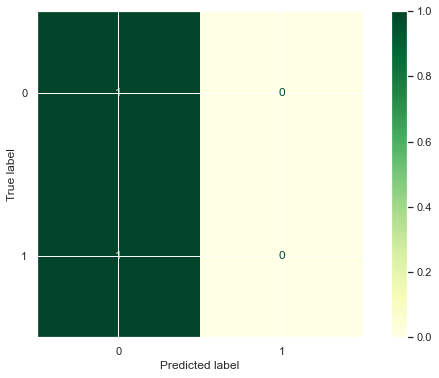

In [30]:
cm_train = confusion_matrix(pred_train_df['TARGET'],
                            pred_train_df['predicted_class'],
                            normalize='true')
print("Matrice de confusion : TRAIN SET")
fig, ax = plt.subplots(figsize=(10, 6))
cm_display = ConfusionMatrixDisplay(cm_train).plot(cmap="YlGn", ax=ax)

In [34]:
print(classification_report(pred_train_df['TARGET'],pred_train_df['predicted_class']))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     49450
         1.0       0.00      0.00      0.00      4366

    accuracy                           0.92     53816
   macro avg       0.46      0.50      0.48     53816
weighted avg       0.84      0.92      0.88     53816



##### Test Set

In [35]:
pred_test_df = pd.DataFrame(index=X_test.index)
pred_test_df['predicted_class'] = clf.predict(X_test[feats])
pred_test_df['TARGET'] = y_test
pred_test_df.shape

(23064, 2)

Matrice de confusion : TEST SET


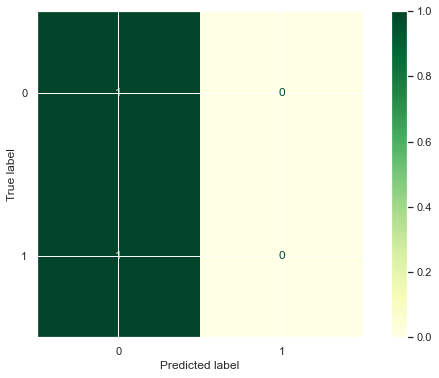

In [36]:
cm_test = confusion_matrix(pred_test_df['TARGET'],
                            pred_test_df['predicted_class'],
                            normalize='true')
print("Matrice de confusion : TEST SET")
fig, ax = plt.subplots(figsize=(10, 6))
cm_display = ConfusionMatrixDisplay(cm_test).plot(cmap="YlGn", ax=ax)

In [37]:
print(classification_report(pred_test_df['TARGET'],pred_test_df['predicted_class']))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     21222
         1.0       0.00      0.00      0.00      1842

    accuracy                           0.92     23064
   macro avg       0.46      0.50      0.48     23064
weighted avg       0.85      0.92      0.88     23064



##### Ce qui pourrait passer pour de très bonnes performances (accuracy de 0,92 !) n’est en fait que le reflet de la surreprésentation de la classe majoritaire. C’est-à-dire que 90% des observations sont correctement classifiées mais la matrice de confusion nous indique une précision et un rappel faible (et même  nul !) pour la classe 1, c’est-à-dire que cette classe n’est pas du tout bien gérée avec la configuration du classifieur utilisée. 

### 2) Personalized metrics : no threshold, proba = 0.5

In [38]:
def custom_metric_static(y_true, y_pred):
    
    TP = 0
    FP = 0
    FN = -10
    TN = 1
    
    final_score = 0
    best_model_score = 0
    model_score = 0
        
    for i in range(len(y_pred)):
        # True positive
        if (y_true[i]==1 and y_pred[i] >= 0.5):
            best_model_score += TP
            model_score += TP
            #print('TP')

        # False positive
        elif (y_true[i]==0 and y_pred[i] >= 0.5):
            best_model_score += TN
            model_score += FP
            #print('FP')

        # False negative
        elif (y_true[i]==1 and y_pred[i] < 0.5):
            best_model_score += TP
            model_score += FN
            #print('FN')

        # true negative
        elif (y_true[i]==0 and y_pred[i] < 0.5):
            best_model_score += TN
            model_score += TN
            #print('TN')
            
        #print('model_score :', model_score)
        #print('best_model:', best_model_score)
            
    final_score = round(model_score/best_model_score, 3)
    print('final_score :', final_score, '\n')

    return ('custom_metric', final_score, True)
    # Need to return those 3 args for the clf.fit()

In [40]:
clf = LGBMClassifier(
            colsample_bytree=0.9497036,
            is_unbalance=True,
            feature_fraction=0.4,
            lambda_l1=4.75,
            lambda_l2=2.2,
            learning_rate=0.03,
            max_depth=7,
            min_child_weight=12.020838819909644,
            min_split_gain=0.016443457513284063,
            num_leaves=25,
            nthread=4,
            n_estimators=10000,
            metric='custom_metric_static',
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            silent=True, # Whether to printprint custom_metric score
            subsample=0.8715623,
            verbose=-1)

In [41]:
# store the predictions 
pred_train = np.zeros(X_train.shape[0])
pred_test = np.zeros(X_test.shape[0])

# Create Folds
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    trn_x, trn_y = X_train[feats].iloc[trn_idx], y_train.iloc[trn_idx]
    val_x, val_y = X_train[feats].iloc[val_idx], y_train.iloc[val_idx]

    clf.fit(trn_x, trn_y,
            #eval_set=[(trn_x, trn_y), (val_x, val_y)], > afficher les score des 2 sets
            eval_set=[(val_x, val_y)],
            eval_metric=custom_metric_static,
            verbose=100,
            early_stopping_rounds=30
            )

    pred_train[val_idx] = clf.predict_proba(val_x,
                                            num_iteration=clf.best_iteration_)[:, 1]
    pred_test += clf.predict_proba(X_test[feats],
                                  num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

    print('\n Fold %2d AUC : %.6f \n\n' %
              (n_fold + 1, roc_auc_score(val_y, pred_train[val_idx])))
    del trn_x, trn_y, val_x, val_y

print('\n Full AUC score %.6f' % roc_auc_score(y_train, pred_train))

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.9497036 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l1 is set=4.75, reg_alpha=0.041545473 will be ignored. Current value: lambda_l1=4.75
[LightGBM] [Warning] lambda_l2 is set=2.2, reg_lambda=0.0735294 will be ignored. Current value: lambda_l2=2.2
final_score : 0.116 

Training until validation scores don't improve for 30 rounds
final_score : 0.116 

final_score : 0.116 

final_score : 0.116 

final_score : 0.116 

final_score : 0.116 

final_score : 0.116 

final_score : 0.116 

final_score : 0.116 

final_score : 0.116 

final_score : 0.116 

final_score : 0.116 

final_score : 0.116 

final_score : 0.116 

final_score : 0.116 

final_score : 0.116 

final_score : 0.116 

final_score : 0.116 

final_score : 0.116 

final_score : 0.116 

final_score : 0.116 

final_score

final_score : 0.326 

final_score : 0.332 

final_score : 0.339 

final_score : 0.344 

final_score : 0.346 

final_score : 0.344 

final_score : 0.353 

final_score : 0.355 

final_score : 0.358 

final_score : 0.365 

final_score : 0.368 

final_score : 0.366 

final_score : 0.375 

final_score : 0.371 

final_score : 0.372 

final_score : 0.372 

final_score : 0.379 

final_score : 0.382 

final_score : 0.384 

final_score : 0.385 

final_score : 0.386 

final_score : 0.384 

final_score : 0.384 

final_score : 0.387 

final_score : 0.39 

final_score : 0.39 

final_score : 0.389 

final_score : 0.388 

final_score : 0.393 

final_score : 0.396 

final_score : 0.396 

final_score : 0.393 

final_score : 0.398 

final_score : 0.396 

final_score : 0.402 

final_score : 0.402 

final_score : 0.405 

final_score : 0.403 

final_score : 0.404 

final_score : 0.4 

final_score : 0.402 

final_score : 0.4 

final_score : 0.401 

final_score : 0.403 

final_score : 0.404 

final_score : 0.

final_score : 0.361 

final_score : 0.36 

final_score : 0.362 

final_score : 0.368 

final_score : 0.372 

final_score : 0.372 

final_score : 0.372 

final_score : 0.37 

final_score : 0.372 

final_score : 0.375 

final_score : 0.379 

final_score : 0.383 

final_score : 0.386 

final_score : 0.387 

final_score : 0.385 

final_score : 0.389 

final_score : 0.389 

final_score : 0.39 

final_score : 0.394 

final_score : 0.393 

final_score : 0.397 

final_score : 0.395 

final_score : 0.397 

final_score : 0.399 

final_score : 0.398 

final_score : 0.398 

final_score : 0.398 

final_score : 0.398 

final_score : 0.4 

final_score : 0.404 

final_score : 0.4 

final_score : 0.401 

final_score : 0.402 

final_score : 0.401 

final_score : 0.404 

final_score : 0.403 

final_score : 0.403 

final_score : 0.401 

final_score : 0.401 

final_score : 0.401 

final_score : 0.402 

final_score : 0.404 

final_score : 0.403 

final_score : 0.403 

final_score : 0.405 

final_score : 0.4

##### Train Set

In [42]:
pred_train_df = pd.DataFrame(index=X_test.index)
pred_train_df['predicted_class'] = clf.predict(X_test[feats])
pred_train_df['TARGET'] = y_test
pred_train_df.shape

(23064, 2)

Matrice de confusion : TRAIN SET


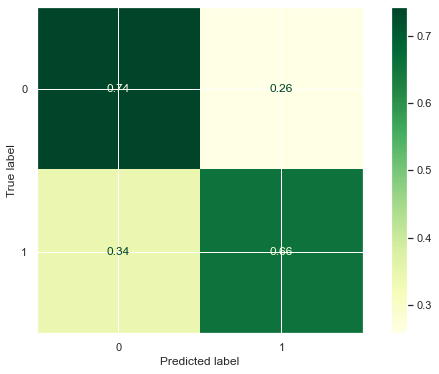

In [43]:
cm_train = confusion_matrix(pred_train_df['TARGET'],
                            pred_train_df['predicted_class'],
                            normalize='true')
print("Matrice de confusion : TRAIN SET")
fig, ax = plt.subplots(figsize=(10, 6))
cm_display = ConfusionMatrixDisplay(cm_train).plot(cmap="YlGn", ax=ax)

In [44]:
print(classification_report(pred_train_df['TARGET'],pred_train_df['predicted_class']))

              precision    recall  f1-score   support

         0.0       0.96      0.74      0.84     21222
         1.0       0.18      0.66      0.28      1842

    accuracy                           0.74     23064
   macro avg       0.57      0.70      0.56     23064
weighted avg       0.90      0.74      0.79     23064



##### Test Set

In [45]:
pred_test_df = pd.DataFrame(index=X_test.index)
pred_test_df['predicted_class'] = clf.predict(X_test[feats])
pred_test_df['TARGET'] = y_test
pred_test_df.shape

(23064, 2)

Matrice de confusion : TEST SET


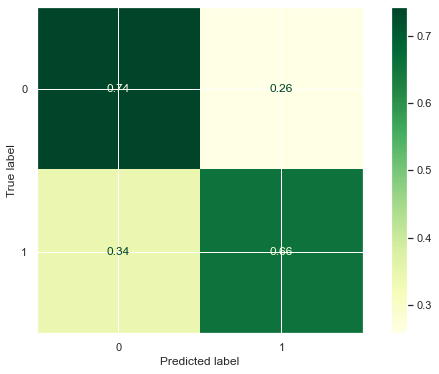

In [46]:
cm_test = confusion_matrix(pred_test_df['TARGET'],
                            pred_test_df['predicted_class'],
                            normalize='true')
print("Matrice de confusion : TEST SET")
fig, ax = plt.subplots(figsize=(10, 6))
cm_display = ConfusionMatrixDisplay(cm_test).plot(cmap="YlGn", ax=ax)

In [47]:
print(classification_report(pred_test_df['TARGET'],pred_test_df['predicted_class']))

              precision    recall  f1-score   support

         0.0       0.96      0.74      0.84     21222
         1.0       0.18      0.66      0.28      1842

    accuracy                           0.74     23064
   macro avg       0.57      0.70      0.56     23064
weighted avg       0.90      0.74      0.79     23064



##### Les résultats sont bien meilleurs ! Recall élévé et faible Précision pour la classe 1 : bien détéctée mais inclue aussi des observations appartenant à la classe 0. On recale donc certains clients alors qu'ils ont en réalité correctement remboursé leur prêt. Erreur mais tolérable > devrait etre diminuée avec un rééquilibrage des classes mis en place avant l'entrainement. 

# -----------------

### 3) Personalized metrics : evolutive threshold

On choisi les coefficients TP, FP, FN et TN de façon arbitraire (cf. Discord) mais on pourait en débatre.

*Piste : utiliser les valeurs banquaires (montant du crédit, interêts, solde non remboursé...)* 

In [22]:
def custom_metric(y_true, y_pred):
    
    TP = 0
    FP = 0
    FN = -10
    TN = 1
    
    final_score = 0
    threshold = 0

    for proba in range(11):
        proba *= 0.1
        #print('proba :', proba)

        # reinitialize the scores to 1
        model_score = 1
        best_model_score = 1
        
        for i in range(len(y_pred)):
            # True positive
            if (y_true[i]==1 and y_pred[i] > proba):
                best_model_score += TP
                model_score += TP
                #print('TP')

            # False positive
            elif (y_true[i]==0 and y_pred[i] > proba):
                best_model_score += TN
                model_score += FP
                #print('FP')

            # False negative
            elif (y_true[i]==1 and y_pred[i] < proba):
                best_model_score += TP
                model_score += FN
                #print('FN')

            # true negative
            elif (y_true[i]==0 and y_pred[i] < proba):
                best_model_score += TN
                model_score += TN
                #print('TN')

            #print('model_score :', model_score)
            #print('best_model:', best_model_score)
            
        proba_score = model_score/best_model_score
        proba_score = round(proba_score, 3)
        #print('proba_score :', proba_score, '\n')
            
        # keep track of the proba that gives the best score
        if proba_score > final_score: 
            final_score = proba_score
            threshold = round(proba, 3)
    print('The best score is {}, for a minimal threshold of {} \n'.format(final_score, threshold))

    return ('custom_metric', final_score, True)
# Need to return those 3 args for the clf.fit()

Besoin de faire une autre fonction pour la visualisation des résultats :

In [23]:
def custom_metric_result(y_true, y_pred):
    
    TP = 0
    FP = 0
    FN = -10
    TN = 1
    
    final_score = 0
    threshold = 0

    for proba in range(11):
        proba *= 0.1
        print('proba :', round(proba, 3))

        # reinitialize the scores to 1
        model_score = 1
        best_model_score = 1
        
        for i in range(len(y_pred)):
            # True positive
            if (y_true.iloc[i]==1 and y_pred.iloc[i] > proba):
                best_model_score += TP
                model_score += TP

            # False positive
            elif (y_true.iloc[i]==0 and y_pred.iloc[i] > proba):
                best_model_score += TN
                model_score += FP

            # False negative
            elif (y_true.iloc[i]==1 and y_pred.iloc[i] < proba):
                best_model_score += TP
                model_score += FN

            # true negative
            elif (y_true.iloc[i]==0 and y_pred.iloc[i] < proba):
                best_model_score += TN
                model_score += TN

            #print('model_score :', model_score)
            #print('best_model:', best_model_score)
            
        proba_score = model_score/best_model_score
        proba_score = round(proba_score, 3)
        print('proba_score :', proba_score, '\n')
            
        # keep track of the proba that gives the best score
        if proba_score > final_score: 
            final_score = proba_score
            threshold = round(proba, 3)
    print('The best score is {}, for a minimal threshold of {} \n'.format(final_score, threshold))

##### Remarque : custom_metric améliorée
- On normalise le score grace à best_model_score et refuse_all_score
- refuse_all_score peut en principe être meilleur que notre model.

Finalement cette 2ème version n'apporte pas grand chose; on ne l'utilisera pas. 

In [17]:
def custom_metricv2(y_true, y_pred):
    
    TP = 0
    FP = 0
    FN = -10
    TN = 1
    
    final_score = 0
    threshold = 0

    for proba in range(11):
        proba *= 0.1
        #print('proba :', proba)

        # reinitialize the scores to 1
        model_score = 1
        best_model_score = 1
        refuse_all_score = 1
        
        for i in range(len(y_pred)):
            # True positive
            if (y_true[i]==1 and y_pred[i] > proba):
                best_model_score += TP
                model_score += TP
                refuse_all_score += FN
                #print('TP')

            # False positive
            elif (y_true[i]==0 and y_pred[i] > proba):
                best_model_score += TN
                model_score += FP
                refuse_all_score += TN
                #print('FP')

            # False negative
            elif (y_true[i]==1 and y_pred[i] < proba):
                best_model_score += TP
                model_score += FN
                refuse_all_score += FN
                #print('FN')

            # true negative
            elif (y_true[i]==0 and y_pred[i] < proba):
                best_model_score += TN
                model_score += TN
                refuse_all_score += TN
                #print('TN')

            #print('model_score :', model_score)
            #print('best_model:', best_model_score)
            
        proba_score = (model_score - refuse_all_score)/(best_model_score - refuse_all_score)
        proba_score = round(proba_score, 3)
        #print('proba_score :', proba_score, '\n')
            
        # keep track of the proba that gives the best score
        if proba_score > final_score: 
            final_score = proba_score
            threshold = round(proba, 3)
    print('The best score is {}, for a minimal threshold of {} \n'.format(final_score, threshold))

    return ('custom_metric', final_score, True)
# Need to return those 3 args for the clf.fit()

##### Dataset unbalanced (sans les feature importances)

In [23]:
# parameters found by BO
clf_base = LGBMClassifier(
            is_unbalance=True,
            feature_fraction= 0.15149664107053287,
            lambda_l1=0.5448495108954549,
            lambda_l2=2.6892362254235733,
            max_depth=8,
            min_child_weight=38.83363857161819,
            min_split_gain=0.028614792065490006,
            num_leaves=35,
            learning_rate=0.03,
            force_col_wise=True, # used only with cpu device type, recommended when the number of columns is large
            subsample=0.8715623,
            verbose=-1, # < 0: Fatal, = 0: Error (Warning), = 1: Info, > 1: Debug 
            random_state=42, 
            metric='custom_metric')

In [24]:
# store the predictions 
pred_train = np.zeros(X_train.shape[0])
pred_test = np.zeros(X_test.shape[0])

feats = [f for f in X_train.columns if f not in ['SK_ID_CURR']]

# Create Folds
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

start_time = timeit.default_timer()
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    trn_x, trn_y = X_train[feats].iloc[trn_idx], y_train.iloc[trn_idx]
    val_x, val_y = X_train[feats].iloc[val_idx], y_train.iloc[val_idx]

    clf_base.fit(trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric=custom_metric,
            verbose=5,
            early_stopping_rounds=30)

    pred_train[val_idx] = clf_base.predict_proba(val_x,
                                            num_iteration=clf_base.best_iteration_)[:, 1]
    pred_test += clf_base.predict_proba(X_test[feats],
                                  num_iteration=clf_base.best_iteration_)[:, 1] / folds.n_splits

    print('\n Fold %2d AUC : %.6f' %
              (n_fold + 1, roc_auc_score(val_y, pred_train[val_idx])))
    del trn_x, trn_y, val_x, val_y
    
Time = timeit.default_timer() - start_time
print("\n Time  =  ", round(Time/60, 2))

[LightGBM] [Warning] feature_fraction is set=0.15149664107053287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15149664107053287
[LightGBM] [Warning] lambda_l1 is set=0.5448495108954549, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5448495108954549
[LightGBM] [Warning] lambda_l2 is set=2.6892362254235733, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6892362254235733
The best score is 0.209, for a minimal threshold of 0.1 

The best score is 0.181, for a minimal threshold of 0.1 

Training until validation scores don't improve for 30 rounds
The best score is 0.27, for a minimal threshold of 0.1 

The best score is 0.222, for a minimal threshold of 0.1 

The best score is 0.127, for a minimal threshold of 0.1 

The best score is 0.116, for a minimal threshold of 0.2 

The best score is 0.117, for a minimal threshold of 0.2 

The best score is 0.116, for a minimal threshold of 0.2 

The best score is 0.117, for a minimal threshold of 0

The best score is 0.573, for a minimal threshold of 0.4 

The best score is 0.415, for a minimal threshold of 0.4 

The best score is 0.572, for a minimal threshold of 0.4 

The best score is 0.41, for a minimal threshold of 0.4 

The best score is 0.571, for a minimal threshold of 0.4 

The best score is 0.414, for a minimal threshold of 0.4 

The best score is 0.572, for a minimal threshold of 0.4 

The best score is 0.416, for a minimal threshold of 0.4 

The best score is 0.571, for a minimal threshold of 0.4 

The best score is 0.415, for a minimal threshold of 0.5 

[65]	training's custom_metric: 0.571	valid_1's custom_metric: 0.415
The best score is 0.571, for a minimal threshold of 0.4 

The best score is 0.415, for a minimal threshold of 0.5 

The best score is 0.57, for a minimal threshold of 0.4 

The best score is 0.417, for a minimal threshold of 0.5 

The best score is 0.57, for a minimal threshold of 0.4 

The best score is 0.42, for a minimal threshold of 0.5 

The best

The best score is 0.4, for a minimal threshold of 0.4 

The best score is 0.578, for a minimal threshold of 0.4 

The best score is 0.407, for a minimal threshold of 0.4 

[45]	training's custom_metric: 0.578	valid_1's custom_metric: 0.407
The best score is 0.577, for a minimal threshold of 0.4 

The best score is 0.4, for a minimal threshold of 0.4 

The best score is 0.578, for a minimal threshold of 0.4 

The best score is 0.404, for a minimal threshold of 0.4 

The best score is 0.576, for a minimal threshold of 0.4 

The best score is 0.407, for a minimal threshold of 0.4 

The best score is 0.577, for a minimal threshold of 0.4 

The best score is 0.406, for a minimal threshold of 0.4 

The best score is 0.579, for a minimal threshold of 0.4 

The best score is 0.405, for a minimal threshold of 0.4 

[50]	training's custom_metric: 0.579	valid_1's custom_metric: 0.405
The best score is 0.577, for a minimal threshold of 0.4 

The best score is 0.401, for a minimal threshold of 0.4 

The best score is 0.534, for a minimal threshold of 0.3 

The best score is 0.423, for a minimal threshold of 0.3 

The best score is 0.53, for a minimal threshold of 0.3 

The best score is 0.421, for a minimal threshold of 0.3 

The best score is 0.524, for a minimal threshold of 0.3 

The best score is 0.41, for a minimal threshold of 0.3 

[30]	training's custom_metric: 0.524	valid_1's custom_metric: 0.41
The best score is 0.52, for a minimal threshold of 0.3 

The best score is 0.407, for a minimal threshold of 0.3 

The best score is 0.511, for a minimal threshold of 0.3 

The best score is 0.396, for a minimal threshold of 0.3 

The best score is 0.506, for a minimal threshold of 0.3 

The best score is 0.398, for a minimal threshold of 0.3 

The best score is 0.505, for a minimal threshold of 0.4 

The best score is 0.389, for a minimal threshold of 0.3 

The best score is 0.52, for a minimal threshold of 0.4 

The best score is 0.387, for a minimal threshold of 0.4 

[35]	trai

The best score is 0.117, for a minimal threshold of 0.2 

[5]	training's custom_metric: 0.117	valid_1's custom_metric: 0.117
The best score is 0.117, for a minimal threshold of 0.2 

The best score is 0.117, for a minimal threshold of 0.2 

The best score is 0.233, for a minimal threshold of 0.2 

The best score is 0.188, for a minimal threshold of 0.2 

The best score is 0.35, for a minimal threshold of 0.2 

The best score is 0.264, for a minimal threshold of 0.2 

The best score is 0.455, for a minimal threshold of 0.2 

The best score is 0.324, for a minimal threshold of 0.2 

The best score is 0.491, for a minimal threshold of 0.2 

The best score is 0.352, for a minimal threshold of 0.2 

[10]	training's custom_metric: 0.491	valid_1's custom_metric: 0.352
The best score is 0.493, for a minimal threshold of 0.2 

The best score is 0.367, for a minimal threshold of 0.2 

The best score is 0.486, for a minimal threshold of 0.2 

The best score is 0.356, for a minimal threshold of 0.

The best score is 0.571, for a minimal threshold of 0.5 

The best score is 0.405, for a minimal threshold of 0.4 

The best score is 0.575, for a minimal threshold of 0.5 

The best score is 0.406, for a minimal threshold of 0.4 

[70]	training's custom_metric: 0.575	valid_1's custom_metric: 0.406
The best score is 0.577, for a minimal threshold of 0.5 

The best score is 0.41, for a minimal threshold of 0.4 

The best score is 0.578, for a minimal threshold of 0.5 

The best score is 0.409, for a minimal threshold of 0.4 

The best score is 0.58, for a minimal threshold of 0.5 

The best score is 0.405, for a minimal threshold of 0.4 

The best score is 0.582, for a minimal threshold of 0.5 

The best score is 0.406, for a minimal threshold of 0.4 

The best score is 0.583, for a minimal threshold of 0.5 

The best score is 0.411, for a minimal threshold of 0.4 

[75]	training's custom_metric: 0.583	valid_1's custom_metric: 0.411
The best score is 0.586, for a minimal threshold of 0.

The best score is 0.408, for a minimal threshold of 0.3 

The best score is 0.528, for a minimal threshold of 0.3 

The best score is 0.406, for a minimal threshold of 0.3 

The best score is 0.522, for a minimal threshold of 0.3 

The best score is 0.406, for a minimal threshold of 0.3 

The best score is 0.519, for a minimal threshold of 0.3 

The best score is 0.401, for a minimal threshold of 0.3 

[30]	training's custom_metric: 0.519	valid_1's custom_metric: 0.401
The best score is 0.512, for a minimal threshold of 0.3 

The best score is 0.398, for a minimal threshold of 0.3 

The best score is 0.505, for a minimal threshold of 0.3 

The best score is 0.395, for a minimal threshold of 0.3 

The best score is 0.503, for a minimal threshold of 0.4 

The best score is 0.392, for a minimal threshold of 0.3 

The best score is 0.515, for a minimal threshold of 0.4 

The best score is 0.401, for a minimal threshold of 0.4 

The best score is 0.525, for a minimal threshold of 0.4 

The 

The best score is 0.607, for a minimal threshold of 0.5 

The best score is 0.444, for a minimal threshold of 0.5 

The best score is 0.607, for a minimal threshold of 0.5 

The best score is 0.443, for a minimal threshold of 0.5 

The best score is 0.609, for a minimal threshold of 0.5 

The best score is 0.44, for a minimal threshold of 0.5 

The best score is 0.609, for a minimal threshold of 0.5 

The best score is 0.44, for a minimal threshold of 0.5 

The best score is 0.609, for a minimal threshold of 0.5 

The best score is 0.44, for a minimal threshold of 0.5 

[95]	training's custom_metric: 0.609	valid_1's custom_metric: 0.44
The best score is 0.611, for a minimal threshold of 0.5 

The best score is 0.44, for a minimal threshold of 0.5 

The best score is 0.611, for a minimal threshold of 0.5 

The best score is 0.439, for a minimal threshold of 0.5 

The best score is 0.613, for a minimal threshold of 0.5 

The best score is 0.438, for a minimal threshold of 0.5 

The best 

In [25]:
custom_metric_result(y_train, pd.Series(pred_train))

proba : 0.0
proba_score : 0.0 

proba : 0.1
proba_score : 0.007 

proba : 0.2
proba_score : 0.137 

proba : 0.3
proba_score : 0.325 

proba : 0.4
proba_score : 0.423 

proba : 0.5
proba_score : 0.365 

proba : 0.6
proba_score : 0.242 

proba : 0.7
proba_score : 0.159 

proba : 0.8
proba_score : 0.118 

proba : 0.9
proba_score : 0.117 

proba : 1.0
proba_score : 0.117 

The best score is 0.423, for a minimal threshold of 0.4 



#### Matrice de confusion sur les jeux train et test.

##### Train set

In [26]:
pred_train_df = pd.DataFrame(index=X_train.index)
pred_train_df['TARGET'] = y_train
pred_train_df['predicted_class'] = clf_base.predict(X_train[feats])
pred_train_df.head()

,TARGET,predicted_class
204,0.00,1.00
35021,0.00,1.00
12905,0.00,1.00
209808,0.00,1.00
265771,0.00,0.00


Matrice de confusion : TRAIN SET


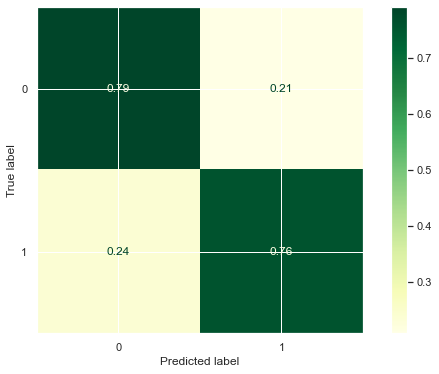

In [27]:
cm_train = confusion_matrix(pred_train_df['TARGET'],
                            pred_train_df['predicted_class'],
                            normalize='true')
print("Matrice de confusion : TRAIN SET")
fig, ax = plt.subplots(figsize=(10, 6))
cm_display = ConfusionMatrixDisplay(cm_train).plot(cmap="YlGn", ax=ax)

In [28]:
print(classification_report(pred_train_df['TARGET'],pred_train_df['predicted_class']))

              precision    recall  f1-score   support

         0.0       0.97      0.79      0.87     49450
         1.0       0.24      0.76      0.37      4366

    accuracy                           0.79     53816
   macro avg       0.61      0.78      0.62     53816
weighted avg       0.91      0.79      0.83     53816



##### Test set

In [56]:
pred_test_df = pd.DataFrame(index=X_test.index)
pred_test_df['TARGET'] = y_test
pred_test_df['predicted_class'] = clf_base.predict(X_test[feats])
pred_test_df.head()

,TARGET,predicted_class
128704,0.00,0.00
200310,0.00,1.00
229727,0.00,0.00
107857,0.00,0.00
244831,1.00,1.00


Matrice de confusion : TEST SET


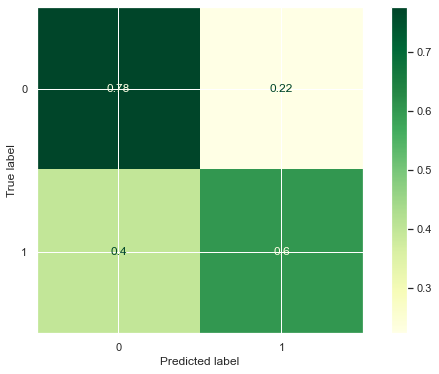

In [57]:
cm_test = confusion_matrix(pred_test_df['TARGET'],
                            pred_test_df['predicted_class'],
                            normalize='true')
print("Matrice de confusion : TEST SET")
fig, ax = plt.subplots(figsize=(10, 6))
cm_display = ConfusionMatrixDisplay(cm_test).plot(cmap="YlGn", ax=ax)

In [58]:
print(classification_report(pred_test_df['TARGET'],pred_test_df['predicted_class']))

              precision    recall  f1-score   support

         0.0       0.96      0.78      0.86     21222
         1.0       0.19      0.60      0.29      1842

    accuracy                           0.76     23064
   macro avg       0.57      0.69      0.57     23064
weighted avg       0.90      0.76      0.81     23064



##### Accuracy relativement normale, recall pas trop mal pour c1, mais precision assez faible : classifieur détacte bien la classe mais encore bcp de clients potentiels sont rejetés sans fondement

# Over/undersampling.

## 1) Oversampling 

In [47]:
# parameters found by BO
clf_ro_base = LGBMClassifier(
            #is_unbalance=True,
            feature_fraction= 0.15149664107053287,
            lambda_l1=0.5448495108954549,
            lambda_l2=2.6892362254235733,
            max_depth=8,
            min_child_weight=38.83363857161819,
            min_split_gain=0.028614792065490006,
            num_leaves=35,
            learning_rate=0.03,
            n_estimators=1000,
            force_col_wise=True, # used only with cpu device type, recommended when the number of columns is large
            verbose=-1, # < 0: Fatal, = 0: Error (Warning), = 1: Info, > 1: Debug 
            random_state=42, 
            metric='custom_metric')

In [48]:
rOs = RandomOverSampler()
X_ro, y_ro = rOs.fit_resample(X_train, y_train)
print('X_ro.shape : ', X_ro.shape)

pred_train_ro = np.zeros(X_ro.shape[0])
pred_test_ro = np.zeros(X_test.shape[0])

feats = [f for f in X_train.columns if f not in ['SK_ID_CURR']]

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

MemoryError: Unable to allocate 252. MiB for an array with shape (334, 98900) and data type float64

In [ ]:
start_time = timeit.default_timer()

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X_ro, y_ro)):
    trn_x, trn_y = X_ro[feats].iloc[trn_idx], y_ro.iloc[trn_idx]
    val_x, val_y = X_ro[feats].iloc[val_idx], y_ro.iloc[val_idx]

    clf_ro_base.fit(trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric=custom_metric,
            verbose=5,
            early_stopping_rounds=30)

    pred_train_ro[val_idx] = clf_ro_base.predict_proba(val_x,
                                            num_iteration=clf_ro_base.best_iteration_,
                                            random_state=42)[:, 1]
    pred_test_ro += clf_ro_base.predict_proba(X_test[feats],
                                  num_iteration=clf_ro_base.best_iteration_,
                                  random_state=42)[:, 1] / folds.n_splits

    print('\n Fold %2d AUC : %.6f' %
              (n_fold + 1, roc_auc_score(val_y, pred_train_ro[val_idx])))
    del trn_x, trn_y, val_x, val_y
    
Time = timeit.default_timer() - start_time
print("\n Time  =  ", round(Time/60, 2))

In [ ]:
custom_metric_result(y_ro, pd.Series(pred_train_ro))

#### Matrice de confusion sur les jeux train et test.

##### Train set 

In [ ]:
pred_train_ro_df = pd.DataFrame(index=X_ro.index)
pred_train_ro_df['TARGET'] = y_ro
pred_train_ro_df['predicted_class'] = clf_ro_base.predict(X_ro[feats])
pred_train_ro_df.head()

In [49]:
cm_train = confusion_matrix(pred_train_ro_df['TARGET'],
                            pred_train_ro_df['predicted_class'],
                            normalize='true')
print("Matrice de confusion : TRAIN SET")
fig, ax = plt.subplots(figsize=(10, 6))
cm_display = ConfusionMatrixDisplay(cm_train).plot(cmap="YlGn", ax=ax)

NameError: name 'pred_train_ro_df' is not defined

In [ ]:
print(classification_report(pred_train_ro_df['TARGET'],pred_train_ro_df['predicted_class']))

##### Test set 

In [ ]:
pred_test_ro_df = pd.DataFrame(index=X_test.index)
pred_test_ro_df['TARGET'] = y_test
pred_test_ro_df['predicted_class'] = clf_ro_base.predict(X_test[feats])
pred_test_ro_df.head()

In [ ]:
cm_test = confusion_matrix(pred_test_ro_df['TARGET'],
                            pred_test_ro_df['predicted_class'],
                            normalize='true')
print("Matrice de confusion : TEST SET")
fig, ax = plt.subplots(figsize=(10, 6))
cm_display = ConfusionMatrixDisplay(cm_train).plot(cmap="YlGn", ax=ax)

In [ ]:
print(classification_report(pred_test_ro_df['TARGET'],pred_test_ro_df['predicted_class']))

## 2) Under_sampling

In [24]:
# parameters found by BO
clf_ru_base = LGBMClassifier(
            #is_unbalance=True,
            feature_fraction= 0.15149664107053287,
            lambda_l1=0.5448495108954549,
            lambda_l2=2.6892362254235733,
            max_depth=8,
            min_child_weight=38.83363857161819,
            min_split_gain=0.028614792065490006,
            num_leaves=35,
            learning_rate=0.03,
            n_estimators=1000,
            force_col_wise=True, # used only with cpu device type, recommended when the number of columns is large
            verbose=-1, # < 0: Fatal, = 0: Error (Warning), = 1: Info, > 1: Debug 
            random_state=42, 
            metric='custom_metric')

In [25]:
rUs = RandomUnderSampler()
X_ru, y_ru = rUs.fit_resample(X_train, y_train)
print('X_ru.shape : ', X_ru.shape)

pred_train_ru = np.zeros(X_ru.shape[0])
pred_test_ru = np.zeros(X_test.shape[0])

feats = [f for f in X_train.columns if f not in ['SK_ID_CURR']]

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

start_time = timeit.default_timer()
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X_ru, y_ru)):
    trn_x, trn_y = X_ru[feats].iloc[trn_idx], y_ru.iloc[trn_idx]
    val_x, val_y = X_ru[feats].iloc[val_idx], y_ru.iloc[val_idx]

    clf_ru_base.fit(trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric=custom_metric,
            verbose=5,
            early_stopping_rounds=30)

    pred_train_ru[val_idx] = clf_ru_base.predict_proba(val_x,
                                                  num_iteration=clf_ru_base.best_iteration_)[:, 1]
    pred_test_ru += clf_ru_base.predict_proba(X_test[feats],
                                         num_iteration=clf_ru_base.best_iteration_)[:, 1] / folds.n_splits
    print('\n Fold %2d AUC : %.6f' %
              (n_fold + 1, roc_auc_score(val_y, pred_train_ru[val_idx])))
    del trn_x, trn_y, val_x, val_y
    
Time = timeit.default_timer() - start_time
print("\n Time  =  ", round(Time/60, 2))

X_ru.shape :  (8732, 673)
[LightGBM] [Warning] feature_fraction is set=0.15149664107053287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15149664107053287
[LightGBM] [Warning] lambda_l1 is set=0.5448495108954549, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5448495108954549
[LightGBM] [Warning] lambda_l2 is set=2.6892362254235733, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6892362254235733
The best score is 0, for a minimal threshold of 0 

The best score is 0.001, for a minimal threshold of 0.0 

Training until validation scores don't improve for 30 rounds
The best score is 0, for a minimal threshold of 0 

The best score is 0.001, for a minimal threshold of 0.0 

The best score is 0, for a minimal threshold of 0 

The best score is 0.001, for a minimal threshold of 0.0 

The best score is 0, for a minimal threshold of 0 

The best score is 0.001, for a minimal threshold of 0.0 

The best score is 0, for a minimal threshold of 0 

The best score is 0.074, for a minimal threshold of 0.3 

The best score is 0.003, for a minimal threshold of 0.2 

The best score is 0.068, for a minimal threshold of 0.3 

The best score is 0.003, for a minimal threshold of 0.2 

The best score is 0.075, for a minimal threshold of 0.3 

The best score is 0.005, for a minimal threshold of 0.2 

The best score is 0.072, for a minimal threshold of 0.3 

The best score is 0.005, for a minimal threshold of 0.2 

The best score is 0.078, for a minimal threshold of 0.3 

The best score is 0.006, for a minimal threshold of 0.2 

[65]	training's custom_metric: 0.078	valid_1's custom_metric: 0.006
Early stopping, best iteration is:
[35]	training's custom_metric: 0.013	valid_1's custom_metric: 0.008

 Fold  1 AUC : 0.771927
[LightGBM] [Warning] feature_fraction is set=0.15149664107053287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15149664107053287
[LightGBM] [Warning] lambda_l1 is set=0.5448495108954549, reg_alpha=

The best score is 0.043, for a minimal threshold of 0.4 

The best score is 0.001, for a minimal threshold of 0.0 

The best score is 0.048, for a minimal threshold of 0.4 

The best score is 0.001, for a minimal threshold of 0.0 

The best score is 0.031, for a minimal threshold of 0.4 

The best score is 0.001, for a minimal threshold of 0.0 

The best score is 0.041, for a minimal threshold of 0.4 

The best score is 0.001, for a minimal threshold of 0.0 

The best score is 0.038, for a minimal threshold of 0.4 

The best score is 0.001, for a minimal threshold of 0.0 

[25]	training's custom_metric: 0.038	valid_1's custom_metric: 0.001
The best score is 0.039, for a minimal threshold of 0.4 

The best score is 0.001, for a minimal threshold of 0.0 

The best score is 0.056, for a minimal threshold of 0.4 

The best score is 0.001, for a minimal threshold of 0.0 

The best score is 0.039, for a minimal threshold of 0.4 

The best score is 0.001, for a minimal threshold of 0.0 

The 

The best score is 0, for a minimal threshold of 0 

The best score is 0.001, for a minimal threshold of 0.0 

The best score is 0, for a minimal threshold of 0 

The best score is 0.001, for a minimal threshold of 0.0 

[10]	training's custom_metric: 0	valid_1's custom_metric: 0.001
The best score is 0.001, for a minimal threshold of 0.4 

The best score is 0.001, for a minimal threshold of 0.0 

The best score is 0.004, for a minimal threshold of 0.4 

The best score is 0.001, for a minimal threshold of 0.0 

The best score is 0.013, for a minimal threshold of 0.4 

The best score is 0.009, for a minimal threshold of 0.4 

The best score is 0.023, for a minimal threshold of 0.4 

The best score is 0.003, for a minimal threshold of 0.4 

The best score is 0.029, for a minimal threshold of 0.4 

The best score is 0.001, for a minimal threshold of 0.0 

[15]	training's custom_metric: 0.029	valid_1's custom_metric: 0.001
The best score is 0.035, for a minimal threshold of 0.4 

The best s

The best score is 0, for a minimal threshold of 0 

The best score is 0.001, for a minimal threshold of 0.0 

The best score is 0, for a minimal threshold of 0 

The best score is 0.001, for a minimal threshold of 0.0 

The best score is 0, for a minimal threshold of 0 

The best score is 0.001, for a minimal threshold of 0.0 

The best score is 0, for a minimal threshold of 0 

The best score is 0.001, for a minimal threshold of 0.0 

[5]	training's custom_metric: 0	valid_1's custom_metric: 0.001
The best score is 0, for a minimal threshold of 0 

The best score is 0.001, for a minimal threshold of 0.0 

The best score is 0, for a minimal threshold of 0 

The best score is 0.001, for a minimal threshold of 0.0 

The best score is 0, for a minimal threshold of 0 

The best score is 0.001, for a minimal threshold of 0.0 

The best score is 0, for a minimal threshold of 0 

The best score is 0.001, for a minimal threshold of 0.0 

The best score is 0, for a minimal threshold of 0 

The b

In [26]:
custom_metric_result(y_ru, pd.Series(pred_train_ru))

proba : 0.0
proba_score : 0.0 

proba : 0.1
proba_score : 0.0 

proba : 0.2
proba_score : 0.0 

proba : 0.3
proba_score : 0.01 

proba : 0.4
proba_score : -0.217 

proba : 0.5
proba_score : -2.61 

proba : 0.6
proba_score : -7.15 

proba : 0.7
proba_score : -8.848 

proba : 0.8
proba_score : -8.998 

proba : 0.9
proba_score : -8.998 

proba : 1.0
proba_score : -8.998 

The best score is 0.01, for a minimal threshold of 0.3 



#### Matrice de confusion sur les jeux train et test.

##### Train set 

In [27]:
pred_train_ru_df = pd.DataFrame(index=X_ru.index)
pred_train_ru_df['TARGET'] = y_ru
pred_train_ru_df['predicted_class'] = clf_ru_base.predict(X_ru[feats])
pred_train_ru_df.head()

,TARGET,predicted_class
0,0.00,0.00
1,0.00,0.00
2,0.00,1.00
3,0.00,1.00
4,0.00,0.00


Matrice de confusion : TRAIN SET


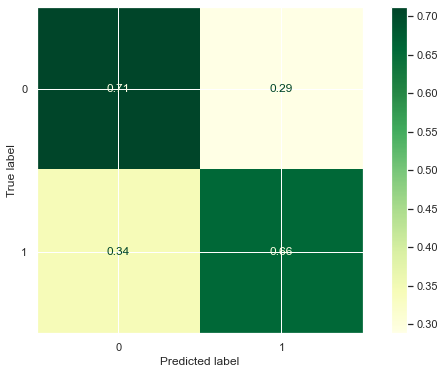

In [28]:
cm_train = confusion_matrix(pred_train_ru_df['TARGET'],
                            pred_train_ru_df['predicted_class'],
                            normalize='true')
print("Matrice de confusion : TRAIN SET")
fig, ax = plt.subplots(figsize=(10, 6))
cm_display = ConfusionMatrixDisplay(cm_train).plot(cmap="YlGn", ax=ax)

In [29]:
print(classification_report(pred_train_ru_df['TARGET'],pred_train_ru_df['predicted_class']))

              precision    recall  f1-score   support

         0.0       0.68      0.71      0.69      4366
         1.0       0.70      0.66      0.68      4366

    accuracy                           0.69      8732
   macro avg       0.69      0.69      0.69      8732
weighted avg       0.69      0.69      0.69      8732



##### Test set 

In [30]:
pred_test_ru_df = pd.DataFrame(index=X_test.index)
pred_test_ru_df['TARGET'] = y_test
pred_test_ru_df['predicted_class'] = clf_ru_base.predict(X_test[feats])
pred_test_ru_df.head()

,TARGET,predicted_class
128704,0.00,0.00
200310,0.00,1.00
229727,0.00,1.00
107857,0.00,1.00
244831,1.00,0.00


Matrice de confusion : TEST SET


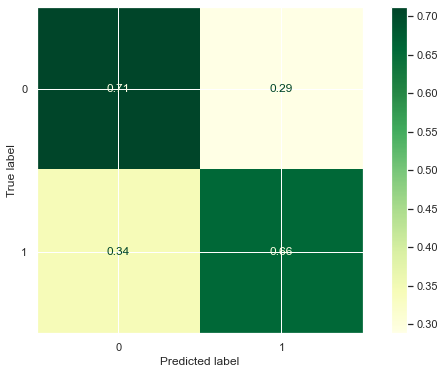

In [31]:
cm_test = confusion_matrix(pred_test_ru_df['TARGET'],
                            pred_test_ru_df['predicted_class'],
                            normalize='true')
print("Matrice de confusion : TEST SET")
fig, ax = plt.subplots(figsize=(10, 6))
cm_display = ConfusionMatrixDisplay(cm_train).plot(cmap="YlGn", ax=ax)

In [32]:
print(classification_report(pred_test_ru_df['TARGET'],pred_test_ru_df['predicted_class']))

              precision    recall  f1-score   support

         0.0       0.96      0.68      0.79     21222
         1.0       0.15      0.64      0.24      1842

    accuracy                           0.68     23064
   macro avg       0.55      0.66      0.52     23064
weighted avg       0.89      0.68      0.75     23064



#### Conclusion :  Quelle méthode garder ? 

L'undersampling et l'oversamplinge donnent des résulats assez similaire avec une meilleur perf pour l'oversampling mzis un temps nettement plus long. On par simplicité et commme les resultats restent très satisfaisants, on utilise l'undersampling pour la suite. 

# Features selection 

In [25]:
# parameters found by BO
clf_ru = LGBMClassifier(
            #is_unbalance=True,
            feature_fraction= 0.15149664107053287,
            lambda_l1=0.5448495108954549,
            lambda_l2=2.6892362254235733,
            max_depth=8,
            min_child_weight=38.83363857161819,
            min_split_gain=0.028614792065490006,
            num_leaves=35,
            learning_rate=0.03,
            n_estimators=1500,
            force_col_wise=True, # used only with cpu device type, recommended when the number of columns is large
            #subsample=0.8715623,
            verbose=-1, # < 0: Fatal, = 0: Error (Warning), = 1: Info, > 1: Debug 
            random_state=42, 
            metric='custom_metric')

In [26]:
rUs = RandomUnderSampler()
X_ru, y_ru = rUs.fit_resample(X_train, y_train)

pred_train_ru = np.zeros(X_ru.shape[0])
pred_test_ru = np.zeros(X_test.shape[0])


# keep track of the features 
feats = [f for f in X_ru.columns if f not in ['SK_ID_CURR']]

# df to store feature importance results 
feature_importance_df = pd.DataFrame()

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [27]:
start_time = timeit.default_timer()

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X_ru, y_ru)):
    trn_x, trn_y = X_ru[feats].iloc[trn_idx], y_ru.iloc[trn_idx]
    val_x, val_y = X_ru[feats].iloc[val_idx], y_ru.iloc[val_idx]

    clf_ru.fit(trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric=custom_metric,
            verbose=5,
            early_stopping_rounds=30)

    pred_train_ru[val_idx] = clf_ru.predict_proba(val_x,
                                            num_iteration=clf_ru.best_iteration_,
                                            random_state=42)[:, 1]
    pred_test_ru += clf_ru.predict_proba(X_test[feats],
                                  num_iteration=clf_ru.best_iteration_,
                                  random_state=42)[:, 1] / folds.n_splits
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf_ru.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    print('\n Fold %2d AUC : %.6f' %
              (n_fold + 1, roc_auc_score(val_y, pred_train_ru[val_idx])))
    del trn_x, trn_y, val_x, val_y
    
Time = timeit.default_timer() - start_time
print("\n Time  =  ", round(Time/60, 2))

[LightGBM] [Warning] feature_fraction is set=0.15149664107053287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15149664107053287
[LightGBM] [Warning] lambda_l1 is set=0.5448495108954549, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5448495108954549
[LightGBM] [Warning] lambda_l2 is set=2.6892362254235733, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6892362254235733
The best score is 0, for a minimal threshold of 0 

The best score is 0.001, for a minimal threshold of 0.0 

Training until validation scores don't improve for 30 rounds
The best score is 0, for a minimal threshold of 0 

The best score is 0.001, for a minimal threshold of 0.0 

The best score is 0, for a minimal threshold of 0 

The best score is 0.001, for a minimal threshold of 0.0 

The best score is 0, for a minimal threshold of 0 

The best score is 0.001, for a minimal threshold of 0.0 

The best score is 0, for a minimal threshold of 0 

The best score is 0.001,

The best score is 0.092, for a minimal threshold of 0.3 

The best score is 0.001, for a minimal threshold of 0.0 

The best score is 0.09, for a minimal threshold of 0.3 

The best score is 0.002, for a minimal threshold of 0.2 

The best score is 0.094, for a minimal threshold of 0.3 

The best score is 0.002, for a minimal threshold of 0.2 

The best score is 0.099, for a minimal threshold of 0.3 

The best score is 0.002, for a minimal threshold of 0.2 

[65]	training's custom_metric: 0.099	valid_1's custom_metric: 0.002
The best score is 0.096, for a minimal threshold of 0.3 

The best score is 0.002, for a minimal threshold of 0.2 

The best score is 0.096, for a minimal threshold of 0.3 

The best score is 0.002, for a minimal threshold of 0.2 

The best score is 0.1, for a minimal threshold of 0.3 

The best score is 0.002, for a minimal threshold of 0.2 

The best score is 0.1, for a minimal threshold of 0.3 

The best score is 0.002, for a minimal threshold of 0.2 

The best 

The best score is 0.051, for a minimal threshold of 0.3 

The best score is 0.001, for a minimal threshold of 0.0 

The best score is 0.049, for a minimal threshold of 0.3 

The best score is 0.001, for a minimal threshold of 0.0 

The best score is 0.06, for a minimal threshold of 0.3 

The best score is 0.001, for a minimal threshold of 0.0 

[50]	training's custom_metric: 0.06	valid_1's custom_metric: 0.001
The best score is 0.054, for a minimal threshold of 0.3 

The best score is 0.001, for a minimal threshold of 0.0 

The best score is 0.058, for a minimal threshold of 0.3 

The best score is 0.001, for a minimal threshold of 0.0 

The best score is 0.062, for a minimal threshold of 0.3 

The best score is 0.001, for a minimal threshold of 0.0 

The best score is 0.064, for a minimal threshold of 0.3 

The best score is 0.001, for a minimal threshold of 0.0 

The best score is 0.063, for a minimal threshold of 0.3 

The best score is 0.001, for a minimal threshold of 0.0 

[55]	t

The best score is 0.019, for a minimal threshold of 0.3 

The best score is 0.015, for a minimal threshold of 0.3 

[40]	training's custom_metric: 0.019	valid_1's custom_metric: 0.015
The best score is 0.022, for a minimal threshold of 0.3 

The best score is 0.021, for a minimal threshold of 0.3 

The best score is 0.025, for a minimal threshold of 0.3 

The best score is 0.017, for a minimal threshold of 0.3 

The best score is 0.029, for a minimal threshold of 0.3 

The best score is 0.01, for a minimal threshold of 0.3 

The best score is 0.034, for a minimal threshold of 0.3 

The best score is 0.011, for a minimal threshold of 0.3 

The best score is 0.037, for a minimal threshold of 0.3 

The best score is 0.003, for a minimal threshold of 0.3 

[45]	training's custom_metric: 0.037	valid_1's custom_metric: 0.003
The best score is 0.039, for a minimal threshold of 0.3 

The best score is 0.01, for a minimal threshold of 0.3 

The best score is 0.044, for a minimal threshold of 0.

The best score is 0.068, for a minimal threshold of 0.4 

The best score is 0.001, for a minimal threshold of 0.0 

The best score is 0.072, for a minimal threshold of 0.4 

The best score is 0.002, for a minimal threshold of 0.3 

The best score is 0.064, for a minimal threshold of 0.4 

The best score is 0.002, for a minimal threshold of 0.3 

[30]	training's custom_metric: 0.064	valid_1's custom_metric: 0.002
The best score is 0.059, for a minimal threshold of 0.4 

The best score is 0.002, for a minimal threshold of 0.3 

The best score is 0.065, for a minimal threshold of 0.4 

The best score is 0.002, for a minimal threshold of 0.3 

The best score is 0.064, for a minimal threshold of 0.4 

The best score is 0.003, for a minimal threshold of 0.3 

The best score is 0.068, for a minimal threshold of 0.4 

The best score is 0.007, for a minimal threshold of 0.3 

The best score is 0.072, for a minimal threshold of 0.4 

The best score is 0.001, for a minimal threshold of 0.0 

[35]

The best score is 0.037, for a minimal threshold of 0.4 

The best score is 0.001, for a minimal threshold of 0.0 

The best score is 0.045, for a minimal threshold of 0.4 

The best score is 0.001, for a minimal threshold of 0.0 

[25]	training's custom_metric: 0.045	valid_1's custom_metric: 0.001
The best score is 0.041, for a minimal threshold of 0.4 

The best score is 0.001, for a minimal threshold of 0.0 

The best score is 0.05, for a minimal threshold of 0.4 

The best score is 0.001, for a minimal threshold of 0.0 

The best score is 0.044, for a minimal threshold of 0.4 

The best score is 0.001, for a minimal threshold of 0.0 

The best score is 0.064, for a minimal threshold of 0.4 

The best score is 0.001, for a minimal threshold of 0.0 

The best score is 0.054, for a minimal threshold of 0.4 

The best score is 0.002, for a minimal threshold of 0.3 

[30]	training's custom_metric: 0.054	valid_1's custom_metric: 0.002
The best score is 0.044, for a minimal threshold of 0

#### Visualisation des features en fonction de leur importance moyenne sur les 5 folds dans la prediction de la classe

In [28]:
ft_imp = pd.DataFrame(feature_importance_df.groupby('feature')['importance'].mean())
ft_imp.sort_values('importance', ascending=False, inplace=True)
ft_imp

,importance
feature,
NEW_EXT_MEAN,31.00
EXT_SOURCE_3,21.80
EXT_SOURCE_2,18.60
NEW_APP_GOODSAMT_CREDIT,15.80
DAYS_BIRTH,14.40
...,...
BUREAU_CREDIT_DAY_OVERDUE_MAX,0.00
PREV_CODE_REJECT_REASON_NAN_MEAN,0.00
PREV_CODE_REJECT_REASON_RARE_MEAN,0.00


#### On cherche à conserver les 200 à 300 features les plus pertinantes

In [30]:
print("Nombre de feature en fonction d'un seuil d' importance minimum :\n")
for i in range (10, 20):
    seuil = i*0.1
    nbr_ft = len(ft_imp[ft_imp['importance']>=seuil])
    print("Seuil mini : {} >> nbr_ft : {}" .format(round(seuil, 1), nbr_ft))

Nombre de feature en fonction d'un seuil d' importance minimum :

Seuil mini : 1.0 >> nbr_ft : 334
Seuil mini : 1.1 >> nbr_ft : 308
Seuil mini : 1.2 >> nbr_ft : 284
Seuil mini : 1.3 >> nbr_ft : 284
Seuil mini : 1.4 >> nbr_ft : 260
Seuil mini : 1.5 >> nbr_ft : 260
Seuil mini : 1.6 >> nbr_ft : 260
Seuil mini : 1.7 >> nbr_ft : 225
Seuil mini : 1.8 >> nbr_ft : 225
Seuil mini : 1.9 >> nbr_ft : 208


#### On choisi un seuil d'importance minimum de 1.8, ce qui conserve 225 features.

In [32]:
new_ft = list(ft_imp[ft_imp['importance']>=1.8].index)
print(len(new_ft))
new_ft

225


['NEW_EXT_MEAN',
 'EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'NEW_APP_GOODSAMT_CREDIT',
 'DAYS_BIRTH',
 'EXT_SOURCE_1',
 'DAYS_EMPLOYED',
 'BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX',
 'BUREAU_DAYS_CREDIT_MEAN',
 'DAYS_LAST_PHONE_CHANGE',
 'NEW_LOAN_VALUE_RATIO',
 'NEW_GOODS_CREDIT',
 'INS_PAYMENT_DIFF_MEAN',
 'BUREAU_DAYS_CREDIT_MEDIAN',
 'INS_DPD_MEAN',
 'ACTIVE_DAYS_CREDIT_MAX',
 'AMT_CREDIT',
 'DAYS_EMPLOYED_PERC',
 'NAME_EDUCATION_TYPE_HIGHER_EDUCATION',
 'PAYMENT_RATE',
 'APPROVED_CNT_PAYMENT_STD',
 'INS_DPD_STD',
 'INS_DPD_SUM',
 'POS_COUNT',
 'DAYS_ID_PUBLISH',
 'APPROVED_APP_CREDIT_PERC_MEAN',
 'BUREAU_DAYS_CREDIT_MAX',
 'INS_AMT_PAYMENT_MIN',
 'INS_DAYS_INSTALMENT_STD',
 'INS_DBD_SUM',
 'CODE_GENDER',
 'POS_CNT_INSTALMENT_FUTURE_MEAN',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN',
 'PREV_AMT_DOWN_PAYMENT_MAX',
 'PREV_CODE_REJECT_REASON_XAP_MEAN',
 'BUREAU_DAYS_CREDIT_ENDDATE_MAX',
 'PREV_CNT_PAYMENT_STD',
 'APPROVED_SELLERPLACE_AREA_MAX',
 'NEW_APP_AGE',
 'INS_AMT_PAYMENT_SUM',
 'PREV_HOUR_APPR_PROCESS

#### On relance le modèle avec ces nouvelles features. (entrainer direct sur tout le jeu, sans CV)

In [33]:
# parameters found by BO
clf_ru = LGBMClassifier(
            #is_unbalance=True,
            feature_fraction= 0.15149664107053287,
            lambda_l1=0.5448495108954549,
            lambda_l2=2.6892362254235733,
            max_depth=8,
            min_child_weight=38.83363857161819,
            min_split_gain=0.028614792065490006,
            num_leaves=35,
            learning_rate=0.03,
            n_estimators=1500,
            force_col_wise=True, # used only with cpu device type, recommended when the number of columns is large
            #subsample=0.8715623,
            verbose=-1, # < 0: Fatal, = 0: Error (Warning), = 1: Info, > 1: Debug 
            random_state=42, 
            metric='custom_metric')

In [34]:
rUs = RandomUnderSampler()
X_ru, y_ru = rUs.fit_resample(X_train, y_train)

clf_ru.fit(X_ru[new_ft], y_ru, eval_metric=custom_metric, verbose=5)

[LightGBM] [Warning] feature_fraction is set=0.15149664107053287, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15149664107053287
[LightGBM] [Warning] lambda_l1 is set=0.5448495108954549, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5448495108954549
[LightGBM] [Warning] lambda_l2 is set=2.6892362254235733, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6892362254235733


LGBMClassifier(feature_fraction=0.15149664107053287, force_col_wise=True,
               lambda_l1=0.5448495108954549, lambda_l2=2.6892362254235733,
               learning_rate=0.03, max_depth=8, metric='custom_metric',
               min_child_weight=38.83363857161819,
               min_split_gain=0.028614792065490006, n_estimators=1500,
               num_leaves=35, random_state=42, verbose=-1)

#### Matrice de confusion sur les jeux train et test.

##### Train set 

In [35]:
pred_train_ru_df = pd.DataFrame(index=X_ru.index)
pred_train_ru_df['TARGET'] = y_ru
pred_train_ru_df['predicted_class'] = clf_ru.predict(X_ru[new_ft])
pred_train_ru_df.head()

,TARGET,predicted_class
0,0.00,0.00
1,0.00,0.00
2,0.00,0.00
3,0.00,0.00
4,0.00,0.00


Matrice de confusion : TRAIN SET


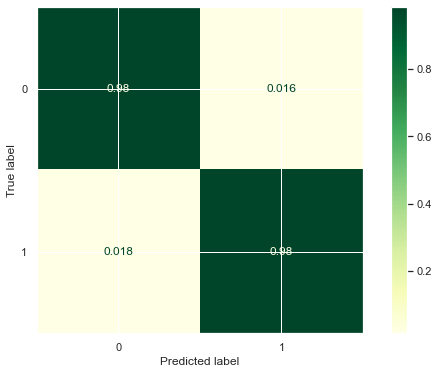

In [36]:
cm_train = confusion_matrix(pred_train_ru_df['TARGET'],
                            pred_train_ru_df['predicted_class'],
                            normalize='true')
print("Matrice de confusion : TRAIN SET")
fig, ax = plt.subplots(figsize=(10, 6))
cm_display = ConfusionMatrixDisplay(cm_train).plot(cmap="YlGn", ax=ax)

In [37]:
print(classification_report(pred_train_ru_df['TARGET'],pred_train_ru_df['predicted_class']))

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98      4366
         1.0       0.98      0.98      0.98      4366

    accuracy                           0.98      8732
   macro avg       0.98      0.98      0.98      8732
weighted avg       0.98      0.98      0.98      8732



##### Test set

In [38]:
pred_test_ru_df = pd.DataFrame(index=X_test.index)
pred_test_ru_df['TARGET'] = y_test
pred_test_ru_df['predicted_class'] = clf_ru.predict(X_test[new_ft])
pred_test_ru_df.head()

,TARGET,predicted_class
128704,0.00,0.00
200310,0.00,1.00
229727,0.00,0.00
107857,0.00,0.00
244831,1.00,1.00


Matrice de confusion : TEST SET


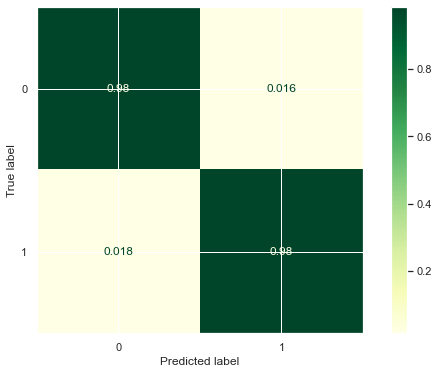

In [39]:
cm_test = confusion_matrix(pred_test_ru_df['TARGET'],
                            pred_test_ru_df['predicted_class'],
                            normalize='true')
print("Matrice de confusion : TEST SET")
fig, ax = plt.subplots(figsize=(10, 6))
cm_display = ConfusionMatrixDisplay(cm_train).plot(cmap="YlGn", ax=ax)

In [40]:
print(classification_report(pred_test_ru_df['TARGET'],pred_test_ru_df['predicted_class']))

              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     21222
         1.0       0.17      0.68      0.27      1842

    accuracy                           0.70     23064
   macro avg       0.56      0.69      0.54     23064
weighted avg       0.90      0.70      0.77     23064



#### Features Importances

In [41]:
feature_importances_df = pd.DataFrame()
feature_importances_df["feature"] = new_ft
feature_importances_df["importance"] = list(clf_ru.feature_importances_[:267])
feature_importances_df.sort_values(by="importance", ascending=False, inplace=True)
feature_importances_df.head()

,feature,importance
208,NEW_INCOME_PER_PERSON_PERC_PAYMENT_RATE_INCOME...,425
0,NEW_EXT_MEAN,399
6,DAYS_EMPLOYED,367
16,AMT_CREDIT,362
24,DAYS_ID_PUBLISH,349


In [86]:
dump(clf_ru, 'model.joblib') 

['model.joblib']

**Remarque sur 'dump' :**

*In the specific case of scikit-learn, it may be better to use joblib’s replacement of pickle (dump & load), which is more efficient on objects that carry large numpy arrays internally as is often the case for fitted scikit-learn estimators, but can only pickle to the disk and not to a string.*

# SHAP
### Display a few graphs

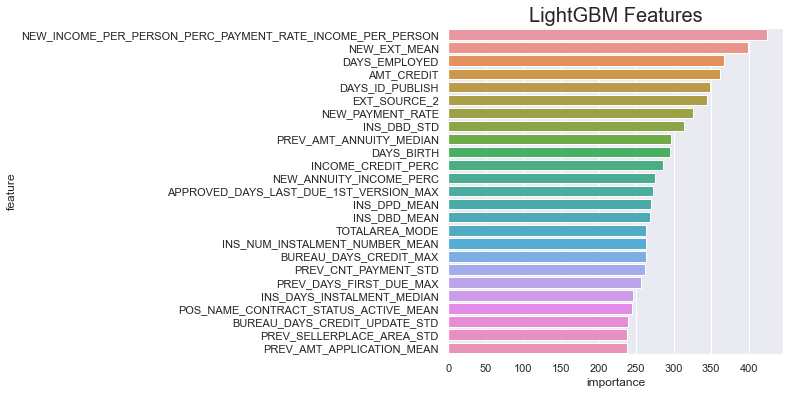

In [42]:
plt.figure(figsize=(6,6))
sns.barplot(x="importance", y="feature", data=feature_importances_df.iloc[:25,:])
plt.title('LightGBM Features', size=20)
plt.tight_layout()
plt.show()

In [43]:
# Concatener Train et Test : no need for shap nor KNN, only on the shortened features
X = pd.concat([X_train[new_ft], X_test[new_ft]])
X_id = pd.concat([Train_id, Test_id])
y = pd.concat([y_train, y_test])

print('X.shape    : ', X.shape)
print('X_id.shape : ', X_id.shape)
print('y.shape    : ', y.shape)

X.shape    :  (76880, 225)
X_id.shape :  (76880,)
y.shape    :  (76880,)


In [44]:
explainer = shap.TreeExplainer(clf_ru, X)
shap_values = explainer( X, check_additivity=False)

100%|===================| 76879/76880 [93:42<00:00]        

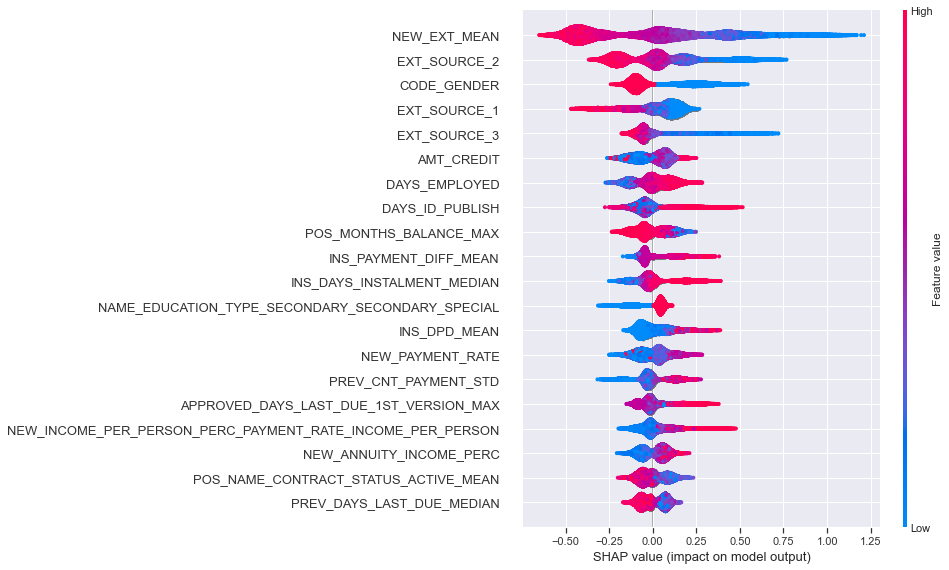

In [45]:
shap.summary_plot(shap_values, X)

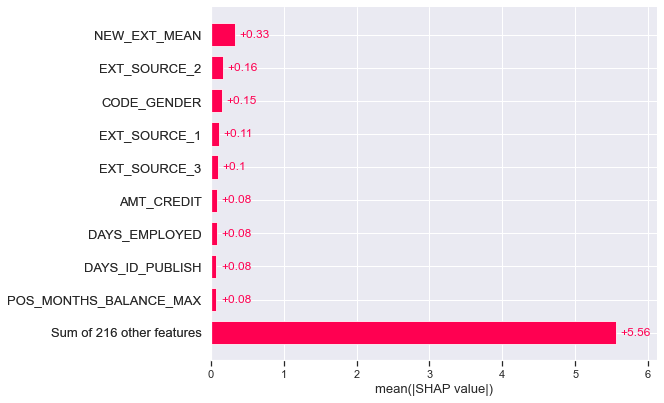

In [46]:
shap.plots.bar(shap_values)

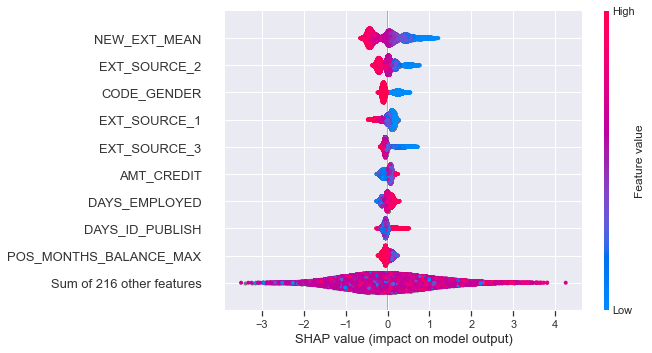

In [47]:
shap.plots.beeswarm(shap_values)

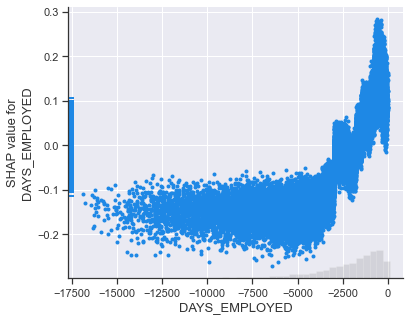

In [48]:
shap.plots.scatter(shap_values[:,"DAYS_EMPLOYED"])

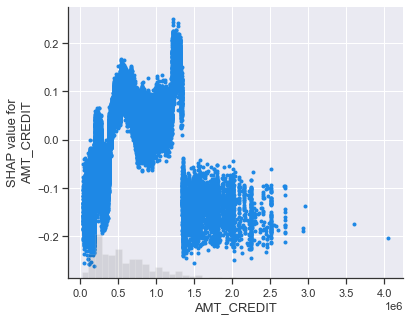

In [49]:
shap.plots.scatter(shap_values[:,"AMT_CREDIT"])

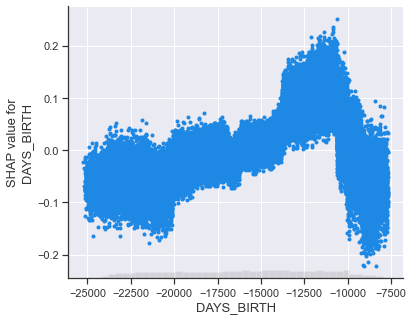

In [50]:
shap.plots.scatter(shap_values[:,"DAYS_BIRTH"])

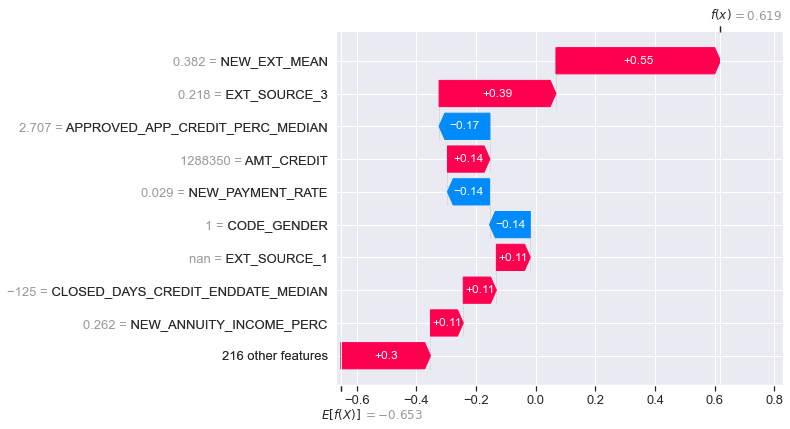

In [51]:
shap.plots.waterfall(shap_values[0])

In [52]:
shap.plots.force(shap_values[0])

In [53]:
shap.plots.force(shap_values)

Exception: In v0.20 force_plot now requires the base value as the first parameter! Try shap.force_plot(explainer.expected_value, shap_values) or for multi-output models try shap.force_plot(explainer.expected_value[0], shap_values[0]).

## K-NN

#### Préparation du df : traitement des Nan et infinity values

In [24]:
# il faut remettre les SK_ID_CURR pour savoir qui est suprimé
X['SK_ID_CURR'] = X_id

In [25]:
# Still need to draw down the effects of unbalancement
rUs = RandomUnderSampler()
X_ru_knn, y_ru_knn = rUs.fit_resample(X, y)
print('X_ru_knn.shape : ', X_ru_knn.shape)

X_ru_knn.shape :  (12416, 268)


In [26]:
# il faut remettre TARGET pour savoir qui va être supprimé
X_y_ru = X_ru_knn
X_y_ru['TARGET'] = y_ru_knn
print('X_y_ru.shape : ',X_y_ru.shape)
X_y_ru.head(2)

X_y_ru.shape :  (12416, 269)


,NEW_EXT_MEAN,EXT_SOURCE_2,DAYS_BIRTH,INS_DPD_MEAN,DAYS_EMPLOYED_PERC,INS_DPD_STD,NEW_APP_GOODSAMT_CREDIT,BUREAU_DAYS_CREDIT_MEDIAN,DAYS_EMPLOYED,EXT_SOURCE_3,EXT_SOURCE_1,NEW_GOODS_CREDIT,BUREAU_DAYS_CREDIT_MEAN,APPROVED_APP_CREDIT_PERC_MEAN,DAYS_LAST_PHONE_CHANGE,BUREAU_DAYS_CREDIT_MAX,PREV_APP_CREDIT_PERC_MEAN,INS_AMT_PAYMENT_SUM,NEW_PAYMENT_RATE,PREV_APP_CREDIT_PERC_MIN,BUREAU_DAYS_CREDIT_ENDDATE_STD,NEW_LOAN_VALUE_RATIO,ACTIVE_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,INS_AMT_PAYMENT_MEDIAN,APPROVED_SELLERPLACE_AREA_MAX,BUREAU_DAYS_CREDIT_UPDATE_MEDIAN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_NAME_CONTRACT_STATUS_REFUSED_MEAN,CODE_GENDER,PAYMENT_RATE,ACTIVE_DAYS_CREDIT_MEAN,INS_PAYMENT_DIFF_MEAN,INS_AMT_PAYMENT_MIN,BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_AMT_CREDIT_SUM_DEBT_MEAN,ACTIVE_DAYS_CREDIT_ENDDATE_SUM,APPROVED_APP_CREDIT_PERC_MEDIAN,INS_DPD_MAX,APPROVED_APP_CREDIT_PERC_MAX,INS_PAYMENT_PERC_MEAN,PREV_CNT_PAYMENT_STD,INS_PAYMENT_DIFF_STD,INS_DAYS_INSTALMENT_STD,PREV_HOUR_APPR_PROCESS_START_MEAN,PREV_CODE_REJECT_REASON_XAP_MEAN,POS_CNT_INSTALMENT_FUTURE_STD,PREV_NAME_CONTRACT_STATUS_APPROVED_MEAN,ACTIVE_DAYS_CREDIT_UPDATE_STD,BUREAU_CREDIT_ACTIVE_ACTIVE_MEAN,INS_DAYS_ENTRY_PAYMENT_STD,PREV_APP_CREDIT_PERC_MEDIAN,INS_PAYMENT_PERC_SUM,INS_DPD_SUM,ANNUITY_INCOME_PERC,INS_DBD_SUM,APPROVED_RATE_DOWN_PAYMENT_MAX,APPROVED_DAYS_LAST_DUE_STD,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,BUREAU_DAYS_CREDIT_ENDDATE_SUM,AMT_ANNUITY,BUREAU_AMT_CREDIT_SUM_DEBT_STD,BUREAU_AMT_CREDIT_SUM_STD,POS_MONTHS_BALANCE_SIZE,NAME_EDUCATION_TYPE_HIGHER_EDUCATION,APARTMENTS_AVG,BUREAU_DAYS_CREDIT_ENDDATE_MAX,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_AMT_CREDIT_SUM_DEBT_MAX,APPROVED_HOUR_APPR_PROCESS_START_MEAN,APPROVED_APP_CREDIT_PERC_MIN,PREV_AMT_ANNUITY_MIN,PREV_DAYS_FIRST_DUE_MIN,POS_COUNT,AMT_GOODS_PRICE,INS_AMT_INSTALMENT_MEDIAN,CLOSED_DAYS_CREDIT_MIN,APPROVED_HOUR_APPR_PROCESS_START_MAX,BUREAU_CREDIT_ACTIVE_CLOSED_MEAN,APPROVED_CNT_PAYMENT_STD,PREV_PRODUCT_COMBINATION_CATS_POS_MEAN,NAME_EDUCATION_TYPE_SECONDARY_SECONDARY_SPECIAL,ACTIVE_DAYS_CREDIT_MEDIAN,BUREAU_DAYS_CREDIT_ENDDATE_MEAN,POS_CNT_INSTALMENT_STD,BUREAU_DAYS_CREDIT_MIN,APPROVED_AMT_DOWN_PAYMENT_MAX,DAYS_ID_PUBLISH,ACTIVE_DAYS_CREDIT_UPDATE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_SUM,CLOSED_AMT_CREDIT_SUM_SUM,APPROVED_AMT_ANNUITY_MEDIAN,PREV_NAME_GOODS_CATEGORY_XNA_MEAN,LIVINGAREA_AVG,BUREAU_DAYS_CREDIT_UPDATE_MEAN,INS_PAYMENT_DIFF_MAX,ACTIVE_AMT_CREDIT_SUM_DEBT_MEDIAN,BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN,PREV_DAYS_LAST_DUE_1ST_VERSION_MAX,PREV_SELLERPLACE_AREA_MEDIAN,PREV_AMT_GOODS_PRICE_MIN,NEW_C_GP,NEW_APP_AGE,CLOSED_DAYS_CREDIT_ENDDATE_MEDIAN,CLOSED_DAYS_CREDIT_MEAN,ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,PREV_AMT_ANNUITY_MEAN,AMT_CREDIT,INS_PAYMENT_DIFF_SUM,PREV_HOUR_APPR_PROCESS_START_MIN,PREV_HOUR_APPR_PROCESS_START_MEDIAN,BUREAU_DAYS_CREDIT_UPDATE_MAX,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_SELLERPLACE_AREA_MAX,APPROVED_AMT_DOWN_PAYMENT_STD,BUREAU_DAYS_CREDIT_ENDDATE_MEDIAN,APPROVED_SELLERPLACE_AREA_MEAN,PREV_DAYS_FIRST_DUE_STD,NEW_ANNUITY_INCOME_PERC,PREV_DAYS_LAST_DUE_MAX,APPROVED_AMT_APPLICATION_MAX,INS_PAYMENT_PERC_STD,PREV_AMT_ANNUITY_STD,PREV_NAME_YIELD_GROUP_HIGH_MEAN,PREV_APP_CREDIT_PERC_STD,APPROVED_HOUR_APPR_PROCESS_START_MEDIAN,CLOSED_DAYS_CREDIT_SUM,CLOSED_DAYS_CREDIT_MEDIAN,CLOSED_AMT_CREDIT_MAX_OVERDUE_SUM,INS_DAYS_INSTALMENT_SUM,POS_CNT_INSTALMENT_FUTURE_MEAN,APPROVED_DAYS_TERMINATION_MAX,PREV_APP_CREDIT_PERC_MAX,APPROVED_AMT_CREDIT_MAX,BUREAU_DAYS_CREDIT_STD,INS_NUM_INSTALMENT_NUMBER_SUM,APPROVED_AMT_GOODS_PRICE_MAX,APPROVED_AMT_GOODS_PRICE_MEDIAN,ACTIVE_AMT_CREDIT_SUM_SUM,PREV_AMT_DOWN_PAYMENT_MEDIAN,PREV_DAYS_TERMINATION_MAX,INS_DAYS_INSTALMENT_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,INS_COUNT,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,INS_DBD_MEAN,POS_CNT_INSTALMENT_FUTURE_SUM,DAYS_REGISTRATION,ACTIVE_DAYS_CREDIT_ENDDATE_STD,PREV_NAME_YIELD_GROUP_LOW_NORMAL_MEAN,NAME_INCOME_TYPE_WORKING,APPROVED_AMT_GOODS_PRICE_MIN,ACTIVE_AMT_CREDIT_SUM_MEDIAN,POS_CNT_INSTALMENT_MEAN,POS_MONTHS_BALANCE_MAX,PREV_RATE_DOWN_PAYMEN

In [27]:
T=round(X_y_ru.count().sum()/(len(X_y_ru)*len(X_y_ru.columns))*100,2)
print('Le taux de remplissage total du dataframe est de :', T,'%' )

Le taux de remplissage total du dataframe est de : 85.2 %


In [28]:
# traiter infinity values
nbr_inf = X_y_ru.isin([np.inf, -np.inf]).sum().sum()
print("infinity values = {} % du df ".format(round(nbr_inf*100/(X_y_ru.shape[0]*X_y_ru.shape[1]),3)))

infinity values = 0.06 % du df 


Vu leur petit nombre, on peut les supprimer. 

In [29]:
X_y_ru = X_y_ru[~(X_y_ru.isin([np.inf, -np.inf]).any(axis=1))]
print('X_y_ru.shape : ', X_y_ru.shape)

X_y_ru.shape :  (10448, 269)


In [31]:
# maintenant qu'on a supprimé les infinity values, on separe à nouveaux le TARGET du reste du df
# on lui rajoute aussi le SK_ID_CURR pour pourvoir faire une jointure à terme
# (en effet le fit_transform ne se fait pas sur cette variable là)
y_ru_knn = X_y_ru[['SK_ID_CURR','TARGET']]
print(y_ru_knn.head(2))
X_ru_knn = X_y_ru.drop(['TARGET'], axis=1)

   SK_ID_CURR  TARGET
0      270381    0.00
2      320150    0.00


In [32]:
imputer = KNNImputer(n_neighbors=3)

In [33]:
X_imputed = imputer.fit_transform(X_ru_knn)
X_imputed

array([[ 5.04882812e-01,  3.51806641e-01, -1.63190000e+04, ...,
         8.44374769e+03, -1.36100000e+03,  2.70381000e+05],
       [ 7.11425781e-01,  7.02148438e-01, -1.59930000e+04, ...,
         4.22148676e+05, -1.27600000e+03,  3.20150000e+05],
       [ 2.59033203e-01,  1.09619141e-01, -1.13470000e+04, ...,
         4.23109766e+05, -1.38900000e+03,  3.79308000e+05],
       ...,
       [ 3.86718750e-01,  6.12792969e-01, -9.39800000e+03, ...,
         1.16804436e+05, -1.29200000e+03,  2.10288000e+05],
       [ 3.34960938e-01,  7.47680664e-02, -1.58560000e+04, ...,
         1.85170760e+05, -1.18100000e+03,  2.51355000e+05],
       [ 5.39062500e-01,  6.37207031e-01, -1.35720000e+04, ...,
         8.69486782e+04, -3.09000000e+02,  1.62865000e+05]])

In [34]:
# Passage en df et nommer les colonnes 
X_imputed = pd.DataFrame(X_imputed)
X_imputed.columns = X_ru_knn.columns
print('X_imputed.shape : ', X_imputed.shape)
X_imputed.head(2)

X_imputed.shape :  (10448, 268)


,NEW_EXT_MEAN,EXT_SOURCE_2,DAYS_BIRTH,INS_DPD_MEAN,DAYS_EMPLOYED_PERC,INS_DPD_STD,NEW_APP_GOODSAMT_CREDIT,BUREAU_DAYS_CREDIT_MEDIAN,DAYS_EMPLOYED,EXT_SOURCE_3,EXT_SOURCE_1,NEW_GOODS_CREDIT,BUREAU_DAYS_CREDIT_MEAN,APPROVED_APP_CREDIT_PERC_MEAN,DAYS_LAST_PHONE_CHANGE,BUREAU_DAYS_CREDIT_MAX,PREV_APP_CREDIT_PERC_MEAN,INS_AMT_PAYMENT_SUM,NEW_PAYMENT_RATE,PREV_APP_CREDIT_PERC_MIN,BUREAU_DAYS_CREDIT_ENDDATE_STD,NEW_LOAN_VALUE_RATIO,ACTIVE_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,INS_AMT_PAYMENT_MEDIAN,APPROVED_SELLERPLACE_AREA_MAX,BUREAU_DAYS_CREDIT_UPDATE_MEDIAN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_NAME_CONTRACT_STATUS_REFUSED_MEAN,CODE_GENDER,PAYMENT_RATE,ACTIVE_DAYS_CREDIT_MEAN,INS_PAYMENT_DIFF_MEAN,INS_AMT_PAYMENT_MIN,BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_AMT_CREDIT_SUM_DEBT_MEAN,ACTIVE_DAYS_CREDIT_ENDDATE_SUM,APPROVED_APP_CREDIT_PERC_MEDIAN,INS_DPD_MAX,APPROVED_APP_CREDIT_PERC_MAX,INS_PAYMENT_PERC_MEAN,PREV_CNT_PAYMENT_STD,INS_PAYMENT_DIFF_STD,INS_DAYS_INSTALMENT_STD,PREV_HOUR_APPR_PROCESS_START_MEAN,PREV_CODE_REJECT_REASON_XAP_MEAN,POS_CNT_INSTALMENT_FUTURE_STD,PREV_NAME_CONTRACT_STATUS_APPROVED_MEAN,ACTIVE_DAYS_CREDIT_UPDATE_STD,BUREAU_CREDIT_ACTIVE_ACTIVE_MEAN,INS_DAYS_ENTRY_PAYMENT_STD,PREV_APP_CREDIT_PERC_MEDIAN,INS_PAYMENT_PERC_SUM,INS_DPD_SUM,ANNUITY_INCOME_PERC,INS_DBD_SUM,APPROVED_RATE_DOWN_PAYMENT_MAX,APPROVED_DAYS_LAST_DUE_STD,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,BUREAU_DAYS_CREDIT_ENDDATE_SUM,AMT_ANNUITY,BUREAU_AMT_CREDIT_SUM_DEBT_STD,BUREAU_AMT_CREDIT_SUM_STD,POS_MONTHS_BALANCE_SIZE,NAME_EDUCATION_TYPE_HIGHER_EDUCATION,APARTMENTS_AVG,BUREAU_DAYS_CREDIT_ENDDATE_MAX,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_AMT_CREDIT_SUM_DEBT_MAX,APPROVED_HOUR_APPR_PROCESS_START_MEAN,APPROVED_APP_CREDIT_PERC_MIN,PREV_AMT_ANNUITY_MIN,PREV_DAYS_FIRST_DUE_MIN,POS_COUNT,AMT_GOODS_PRICE,INS_AMT_INSTALMENT_MEDIAN,CLOSED_DAYS_CREDIT_MIN,APPROVED_HOUR_APPR_PROCESS_START_MAX,BUREAU_CREDIT_ACTIVE_CLOSED_MEAN,APPROVED_CNT_PAYMENT_STD,PREV_PRODUCT_COMBINATION_CATS_POS_MEAN,NAME_EDUCATION_TYPE_SECONDARY_SECONDARY_SPECIAL,ACTIVE_DAYS_CREDIT_MEDIAN,BUREAU_DAYS_CREDIT_ENDDATE_MEAN,POS_CNT_INSTALMENT_STD,BUREAU_DAYS_CREDIT_MIN,APPROVED_AMT_DOWN_PAYMENT_MAX,DAYS_ID_PUBLISH,ACTIVE_DAYS_CREDIT_UPDATE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_SUM,CLOSED_AMT_CREDIT_SUM_SUM,APPROVED_AMT_ANNUITY_MEDIAN,PREV_NAME_GOODS_CATEGORY_XNA_MEAN,LIVINGAREA_AVG,BUREAU_DAYS_CREDIT_UPDATE_MEAN,INS_PAYMENT_DIFF_MAX,ACTIVE_AMT_CREDIT_SUM_DEBT_MEDIAN,BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN,PREV_DAYS_LAST_DUE_1ST_VERSION_MAX,PREV_SELLERPLACE_AREA_MEDIAN,PREV_AMT_GOODS_PRICE_MIN,NEW_C_GP,NEW_APP_AGE,CLOSED_DAYS_CREDIT_ENDDATE_MEDIAN,CLOSED_DAYS_CREDIT_MEAN,ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,PREV_AMT_ANNUITY_MEAN,AMT_CREDIT,INS_PAYMENT_DIFF_SUM,PREV_HOUR_APPR_PROCESS_START_MIN,PREV_HOUR_APPR_PROCESS_START_MEDIAN,BUREAU_DAYS_CREDIT_UPDATE_MAX,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_SELLERPLACE_AREA_MAX,APPROVED_AMT_DOWN_PAYMENT_STD,BUREAU_DAYS_CREDIT_ENDDATE_MEDIAN,APPROVED_SELLERPLACE_AREA_MEAN,PREV_DAYS_FIRST_DUE_STD,NEW_ANNUITY_INCOME_PERC,PREV_DAYS_LAST_DUE_MAX,APPROVED_AMT_APPLICATION_MAX,INS_PAYMENT_PERC_STD,PREV_AMT_ANNUITY_STD,PREV_NAME_YIELD_GROUP_HIGH_MEAN,PREV_APP_CREDIT_PERC_STD,APPROVED_HOUR_APPR_PROCESS_START_MEDIAN,CLOSED_DAYS_CREDIT_SUM,CLOSED_DAYS_CREDIT_MEDIAN,CLOSED_AMT_CREDIT_MAX_OVERDUE_SUM,INS_DAYS_INSTALMENT_SUM,POS_CNT_INSTALMENT_FUTURE_MEAN,APPROVED_DAYS_TERMINATION_MAX,PREV_APP_CREDIT_PERC_MAX,APPROVED_AMT_CREDIT_MAX,BUREAU_DAYS_CREDIT_STD,INS_NUM_INSTALMENT_NUMBER_SUM,APPROVED_AMT_GOODS_PRICE_MAX,APPROVED_AMT_GOODS_PRICE_MEDIAN,ACTIVE_AMT_CREDIT_SUM_SUM,PREV_AMT_DOWN_PAYMENT_MEDIAN,PREV_DAYS_TERMINATION_MAX,INS_DAYS_INSTALMENT_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,INS_COUNT,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,INS_DBD_MEAN,POS_CNT_INSTALMENT_FUTURE_SUM,DAYS_REGISTRATION,ACTIVE_DAYS_CREDIT_ENDDATE_STD,PREV_NAME_YIELD_GROUP_LOW_NORMAL_MEAN,NAME_INCOME_TYPE_WORKING,APPROVED_AMT_GOODS_PRICE_MIN,ACTIVE_AMT_CREDIT_SUM_MEDIAN,POS_CNT_INSTALMENT_MEAN,POS_MONTHS_BALANCE_MAX,PREV_RATE_DOWN_PAYMEN

In [35]:
X_imputed.to_csv('X_ready.csv', index=False)

In [37]:
y_ru_knn.to_csv('y_ready.csv', index=False)

In [44]:
X_imputed.SK_ID_CURR.min()

100002.0

In [43]:
X_imputed[X_imputed.SK_ID_CURR.isin(client0_skid)]

,NEW_EXT_MEAN,EXT_SOURCE_2,DAYS_BIRTH,INS_DPD_MEAN,DAYS_EMPLOYED_PERC,INS_DPD_STD,NEW_APP_GOODSAMT_CREDIT,BUREAU_DAYS_CREDIT_MEDIAN,DAYS_EMPLOYED,EXT_SOURCE_3,EXT_SOURCE_1,NEW_GOODS_CREDIT,BUREAU_DAYS_CREDIT_MEAN,APPROVED_APP_CREDIT_PERC_MEAN,DAYS_LAST_PHONE_CHANGE,BUREAU_DAYS_CREDIT_MAX,PREV_APP_CREDIT_PERC_MEAN,INS_AMT_PAYMENT_SUM,NEW_PAYMENT_RATE,PREV_APP_CREDIT_PERC_MIN,BUREAU_DAYS_CREDIT_ENDDATE_STD,NEW_LOAN_VALUE_RATIO,ACTIVE_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_ENDDATE_MAX,INS_AMT_PAYMENT_MEDIAN,APPROVED_SELLERPLACE_AREA_MAX,BUREAU_DAYS_CREDIT_UPDATE_MEDIAN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_NAME_CONTRACT_STATUS_REFUSED_MEAN,CODE_GENDER,PAYMENT_RATE,ACTIVE_DAYS_CREDIT_MEAN,INS_PAYMENT_DIFF_MEAN,INS_AMT_PAYMENT_MIN,BUREAU_AMT_CREDIT_MAX_OVERDUE_MAX,BUREAU_AMT_CREDIT_SUM_DEBT_MEAN,ACTIVE_DAYS_CREDIT_ENDDATE_SUM,APPROVED_APP_CREDIT_PERC_MEDIAN,INS_DPD_MAX,APPROVED_APP_CREDIT_PERC_MAX,INS_PAYMENT_PERC_MEAN,PREV_CNT_PAYMENT_STD,INS_PAYMENT_DIFF_STD,INS_DAYS_INSTALMENT_STD,PREV_HOUR_APPR_PROCESS_START_MEAN,PREV_CODE_REJECT_REASON_XAP_MEAN,POS_CNT_INSTALMENT_FUTURE_STD,PREV_NAME_CONTRACT_STATUS_APPROVED_MEAN,ACTIVE_DAYS_CREDIT_UPDATE_STD,BUREAU_CREDIT_ACTIVE_ACTIVE_MEAN,INS_DAYS_ENTRY_PAYMENT_STD,PREV_APP_CREDIT_PERC_MEDIAN,INS_PAYMENT_PERC_SUM,INS_DPD_SUM,ANNUITY_INCOME_PERC,INS_DBD_SUM,APPROVED_RATE_DOWN_PAYMENT_MAX,APPROVED_DAYS_LAST_DUE_STD,ACTIVE_DAYS_CREDIT_ENDDATE_MEAN,BUREAU_DAYS_CREDIT_ENDDATE_SUM,AMT_ANNUITY,BUREAU_AMT_CREDIT_SUM_DEBT_STD,BUREAU_AMT_CREDIT_SUM_STD,POS_MONTHS_BALANCE_SIZE,NAME_EDUCATION_TYPE_HIGHER_EDUCATION,APARTMENTS_AVG,BUREAU_DAYS_CREDIT_ENDDATE_MAX,BUREAU_AMT_CREDIT_SUM_DEBT_SUM,BUREAU_AMT_CREDIT_SUM_DEBT_MAX,APPROVED_HOUR_APPR_PROCESS_START_MEAN,APPROVED_APP_CREDIT_PERC_MIN,PREV_AMT_ANNUITY_MIN,PREV_DAYS_FIRST_DUE_MIN,POS_COUNT,AMT_GOODS_PRICE,INS_AMT_INSTALMENT_MEDIAN,CLOSED_DAYS_CREDIT_MIN,APPROVED_HOUR_APPR_PROCESS_START_MAX,BUREAU_CREDIT_ACTIVE_CLOSED_MEAN,APPROVED_CNT_PAYMENT_STD,PREV_PRODUCT_COMBINATION_CATS_POS_MEAN,NAME_EDUCATION_TYPE_SECONDARY_SECONDARY_SPECIAL,ACTIVE_DAYS_CREDIT_MEDIAN,BUREAU_DAYS_CREDIT_ENDDATE_MEAN,POS_CNT_INSTALMENT_STD,BUREAU_DAYS_CREDIT_MIN,APPROVED_AMT_DOWN_PAYMENT_MAX,DAYS_ID_PUBLISH,ACTIVE_DAYS_CREDIT_UPDATE_MAX,BUREAU_AMT_CREDIT_MAX_OVERDUE_SUM,CLOSED_AMT_CREDIT_SUM_SUM,APPROVED_AMT_ANNUITY_MEDIAN,PREV_NAME_GOODS_CATEGORY_XNA_MEAN,LIVINGAREA_AVG,BUREAU_DAYS_CREDIT_UPDATE_MEAN,INS_PAYMENT_DIFF_MAX,ACTIVE_AMT_CREDIT_SUM_DEBT_MEDIAN,BUREAU_AMT_CREDIT_MAX_OVERDUE_MEAN,PREV_DAYS_LAST_DUE_1ST_VERSION_MAX,PREV_SELLERPLACE_AREA_MEDIAN,PREV_AMT_GOODS_PRICE_MIN,NEW_C_GP,NEW_APP_AGE,CLOSED_DAYS_CREDIT_ENDDATE_MEDIAN,CLOSED_DAYS_CREDIT_MEAN,ACTIVE_AMT_CREDIT_SUM_DEBT_MEAN,PREV_AMT_ANNUITY_MEAN,AMT_CREDIT,INS_PAYMENT_DIFF_SUM,PREV_HOUR_APPR_PROCESS_START_MIN,PREV_HOUR_APPR_PROCESS_START_MEDIAN,BUREAU_DAYS_CREDIT_UPDATE_MAX,PREV_AMT_DOWN_PAYMENT_MEAN,PREV_SELLERPLACE_AREA_MAX,APPROVED_AMT_DOWN_PAYMENT_STD,BUREAU_DAYS_CREDIT_ENDDATE_MEDIAN,APPROVED_SELLERPLACE_AREA_MEAN,PREV_DAYS_FIRST_DUE_STD,NEW_ANNUITY_INCOME_PERC,PREV_DAYS_LAST_DUE_MAX,APPROVED_AMT_APPLICATION_MAX,INS_PAYMENT_PERC_STD,PREV_AMT_ANNUITY_STD,PREV_NAME_YIELD_GROUP_HIGH_MEAN,PREV_APP_CREDIT_PERC_STD,APPROVED_HOUR_APPR_PROCESS_START_MEDIAN,CLOSED_DAYS_CREDIT_SUM,CLOSED_DAYS_CREDIT_MEDIAN,CLOSED_AMT_CREDIT_MAX_OVERDUE_SUM,INS_DAYS_INSTALMENT_SUM,POS_CNT_INSTALMENT_FUTURE_MEAN,APPROVED_DAYS_TERMINATION_MAX,PREV_APP_CREDIT_PERC_MAX,APPROVED_AMT_CREDIT_MAX,BUREAU_DAYS_CREDIT_STD,INS_NUM_INSTALMENT_NUMBER_SUM,APPROVED_AMT_GOODS_PRICE_MAX,APPROVED_AMT_GOODS_PRICE_MEDIAN,ACTIVE_AMT_CREDIT_SUM_SUM,PREV_AMT_DOWN_PAYMENT_MEDIAN,PREV_DAYS_TERMINATION_MAX,INS_DAYS_INSTALMENT_MEAN,PREV_CODE_REJECT_REASON_HC_MEAN,INS_COUNT,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,INS_DBD_MEAN,POS_CNT_INSTALMENT_FUTURE_SUM,DAYS_REGISTRATION,ACTIVE_DAYS_CREDIT_ENDDATE_STD,PREV_NAME_YIELD_GROUP_LOW_NORMAL_MEAN,NAME_INCOME_TYPE_WORKING,APPROVED_AMT_GOODS_PRICE_MIN,ACTIVE_AMT_CREDIT_SUM_MEDIAN,POS_CNT_INSTALMENT_MEAN,POS_MONTHS_BALANCE_MAX,PREV_RATE_DOWN_PAYMEN

In [41]:
client0_skid = y_ru_knn.SK_ID_CURR[y_ru_knn.TARGET==0]
client0_skid

0       270381
2       320150
3       379308
4       156177
5       334513
         ...  
6203    362734
6204    256321
6205    142910
6206    290336
6207    129911
Name: SK_ID_CURR, Length: 5114, dtype: int32

#### GridSearchCV

In [126]:
def para(k_min,k_max,pas, knn, X_train, ytrain):
    parameters = {'n_neighbors':[i for i in range(k_min,k_max,pas)]}
    clf = GridSearchCV(knn, parameters, verbose=5)
    clf.fit(X_train, ytrain)
    print (clf.best_estimator_)
    return(clf.best_estimator_)

In [128]:
knn = para(1,200,10,KNeighborsClassifier(), X_imputed, y_ru_knn.TARGET)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ..................................n_neighbors=1; total time=   0.4s
[CV 2/5] END ..................................n_neighbors=1; total time=   0.3s
[CV 3/5] END ..................................n_neighbors=1; total time=   0.3s
[CV 4/5] END ..................................n_neighbors=1; total time=   0.3s
[CV 5/5] END ..................................n_neighbors=1; total time=   0.3s
[CV 1/5] END .................................n_neighbors=11; total time=   0.5s
[CV 2/5] END .................................n_neighbors=11; total time=   0.4s
[CV 3/5] END .................................n_neighbors=11; total time=   0.4s
[CV 4/5] END .................................n_neighbors=11; total time=   0.4s
[CV 5/5] END .................................n_neighbors=11; total time=   0.5s
[CV 1/5] END .................................n_neighbors=21; total time=   0.4s
[CV 2/5] END .................................n

In [129]:
knn = para(115,125,1,KNeighborsClassifier(), X_imputed, y_ru_knn.TARGET)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ................................n_neighbors=115; total time=   0.5s
[CV 2/5] END ................................n_neighbors=115; total time=   0.5s
[CV 3/5] END ................................n_neighbors=115; total time=   0.4s
[CV 4/5] END ................................n_neighbors=115; total time=   0.5s
[CV 5/5] END ................................n_neighbors=115; total time=   0.5s
[CV 1/5] END ................................n_neighbors=116; total time=   0.5s
[CV 2/5] END ................................n_neighbors=116; total time=   0.4s
[CV 3/5] END ................................n_neighbors=116; total time=   0.4s
[CV 4/5] END ................................n_neighbors=116; total time=   0.4s
[CV 5/5] END ................................n_neighbors=116; total time=   0.5s
[CV 1/5] END ................................n_neighbors=117; total time=   0.5s
[CV 2/5] END ................................n_n

In [130]:
knn = KNeighborsClassifier(n_neighbors=121)
knn.fit(X_imputed, y_ru_knn.TARGET)

KNeighborsClassifier(n_neighbors=121)

In [131]:
dump(knn, 'knn.joblib') 

['knn.joblib']